In [2]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag
from numpy import linalg as LA


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
xinj_to_Einj = 4.698e-4/2. #Einj = 4.698e-4/2 xinj
mass_to_Einj = 1./2.
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass,  ' +r'$m_\mathrm{X}\quad[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"

label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'
sd = pi


find_nearests = sd.find_nearests
#from scipy.interpolate import interp1d

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict

def pi_run_pca_constraints_with_recfast(xinj_values,gammai_array,fdm,*args,**kwargs):
    PCA_eigen_modes = kwargs['PCA_modes']
    recfast = kwargs['recfast']
    f_dm_pca = {}
    f_dm_pca['curves'] = []
    f_dm_pca['xinj'] = []
    
    store_DXe_Xe = kwargs.get('store_DXe_Xe', 'no')
    
    
    z1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['z']
    E1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['values']
    z2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['z']
    E2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['values']
    z3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['z']
    E3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['values']
    
    f_E1 = interp1d(z1, E1)
    f_E2 = interp1d(z2, E2)
    f_E3 = interp1d(z3, E3)

    
    for xinj_asked in xinj_values:
        xdec = xinj_asked
        curves = {}
        curves['Gamma_inj'] = gammai_array
        if store_DXe_Xe == 'yes':
            curves['DXe_Xe'] = []

        #str_dir = str("%.3e"%xdec)

        recfast.rf_xinj0 = xdec
        recfast.rf_f_dec = fdm

        args = {}

        p_name = 'Gamma_dec'
        p_array = gammai_array

        args['param_values_array'] = p_array
        args['param_name'] = p_name
        args['save_recfast_results'] = 'no'
        #rf.save_dir_name = 'case_' + '_xdec_' + str_dir
        R = recfast.run_recfast_parallel(**args)


        recfast.rf_f_dec = 1.e-300
        #recfast.save_dir_name = 'case_no_inj' + '_xdec_' + str_dir
        R_no_inj = recfast.run_recfast_parallel(**args) 
        
        
        
        fdm_pca_array = []
        for k in range(len(R)):
            DXe_Xe = (R[k]['Xe']-R_no_inj[k]['Xe'])/R_no_inj[k]['Xe']
            z_Xe = R[k]['z']
            f_DXe_Xe = interp1d(z_Xe,DXe_Xe)
            
            min_z1 = max(np.min(z1),np.min(z_Xe))
            max_z1 = min(np.max(z1),np.max(z_Xe))

            min_z2 = max(np.min(z2),np.min(z_Xe))
            max_z2 = min(np.max(z2),np.max(z_Xe))

            min_z3 = max(np.min(z3),np.min(z_Xe))
            max_z3 = min(np.max(z3),np.max(z_Xe))
            
            new_z_min = max(min_z1,min_z2,min_z3)
            new_z_max = min(max_z1,max_z2,max_z3)
            
            new_z_min = 1e-5
            new_z_max = 4e3
            new_z = np.linspace(new_z_min,new_z_max,500)

            
            new_z1 = new_z#np.linspace(min_z1,max_z1,5000)
            new_z2 = new_z#np.linspace(min_z2,max_z2,5000)
            new_z3 = new_z#np.linspace(min_z3,max_z3,5000)
            
            zeta1 = f_DXe_Xe(new_z1)
            zeta2 = f_DXe_Xe(new_z2)
            zeta3 = f_DXe_Xe(new_z3)

            integrand_rho1 = zeta1*f_E1(new_z1)
            integrand_rho2 = zeta2*f_E2(new_z2)
            integrand_rho3 = zeta3*f_E3(new_z3)
            
            

            rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
            rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
            rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
            #print(rho1,rho2,rho3)

            sigma1 = 0.12
            sigma2 = 0.19
            sigma3 = 0.35

            fdm_pca_lim = 2.*1./np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
            fdm_pca_array.append(fdm_pca_lim)
            if store_DXe_Xe == 'yes':
                curves['DXe_Xe'].append([new_z,f_DXe_Xe(new_z)])
                
            
        fdm_pca_array = np.asarray(fdm_pca_array)
        curves['fdm'] = fdm_pca_array
        
        
        
        
        
        f_dm_pca['xinj'].append(xdec)
        f_dm_pca['curves'].append(curves)
    return f_dm_pca


import matplotlib.animation as animation

In [3]:
def pi_compute_fdm_constraints(log10_tau_a,log10_Einj_in_ev,asd_lib,*args,**kwargs):
    Einj_in_ev = 10**log10_Einj_in_ev
    tau_a = 10**log10_tau_a
    #ma_in_ev = log10_ma_in_ev
    #tau_a = log10_tau_a
    xinj = Einj_in_ev/xinj_to_Einj
    #gagg = 3.57e7*(Gamma_values)**0.5*Xinj_values**(-3./2.)
    Gamma = 1./tau_a#((gagg/3.57e7)/xinj**(-3./2.))**2.
    # for short lifetime, we compute the constraint
    # analytically using the mu-distortion
    if Gamma>1e-8:
        ct = sd.cosmotherm()
        cosmo = sd.cosmo()
        X_dm = sd.dm_particle()
        pi.set_dm_params_to_CT_pi_params(X_dm,ct)
        pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
        
        X_dm.Gamma_inj = Gamma
        X_dm.x_0 = xinj
        fdm_constraint = np.abs(pi.high_redshift_f_dm_limit(7.4e-5,cosmo,ct,X_dm,N_int = 5))
    # for long lifetime, we compute the constraint
    # by extrapolating
    elif Gamma < asd_lib.Gamma_inj_min:
        xi_a = [xinj]
        Gamma_values = [asd_lib.Gamma_inj_min]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,asd_lib,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']*asd_lib.Gamma_inj_min/Gamma
    # for intermerdiate cases we compute the constraints using fisher matrix
    else:
        xi_a = [xinj]
        Gamma_values = [Gamma]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,asd_lib,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']
    return np.log10(fdm_constraint)

pi_compute_fdm_constraints = np.vectorize(pi_compute_fdm_constraints)




In [4]:
A = np.logspace(-21,-30,10)
B = np.logspace(-8,-20,20)
np.concatenate((B,A))

array([1.00000000e-08, 2.33572147e-09, 5.45559478e-10, 1.27427499e-10,
       2.97635144e-11, 6.95192796e-12, 1.62377674e-12, 3.79269019e-13,
       8.85866790e-14, 2.06913808e-14, 4.83293024e-15, 1.12883789e-15,
       2.63665090e-16, 6.15848211e-17, 1.43844989e-17, 3.35981829e-18,
       7.84759970e-19, 1.83298071e-19, 4.28133240e-20, 1.00000000e-20,
       1.00000000e-21, 1.00000000e-22, 1.00000000e-23, 1.00000000e-24,
       1.00000000e-25, 1.00000000e-26, 1.00000000e-27, 1.00000000e-28,
       1.00000000e-29, 1.00000000e-30])

In [4]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_without_collision_20x20_170820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_20x20_stim_190820',sd_lib_extended_run)
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_190820',sd_lib_extended_run)

#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_5e-6_no_collision_160820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [6]:
ct = sd.cosmotherm()
cosmo = sd.cosmo()
firas = sd.firas()
edges = sd.edges()
X_dm = sd.dm_particle()
rf = sd.recfast()
PCA_modes = sd.Xe_PCA_EigenModes()

In [9]:
#case = 'lyc+reio'
add_edges = 'yes'

tau_values = np.linspace(5,30,200)
Einj_values =np.linspace(-10,5,200)
xlist = Einj_values
ylist = tau_values

X, Y = np.meshgrid(xlist, ylist)

a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges

if add_edges == 'yes':
    a_dict['add_edges'] = 'yes'
else:
    a_dict['add_edges'] = 'no'

#lib = sd_lib_lyc_reio
lib = sd_lib_extended_run


#Z = vfunc_tau_a_contours(Y,X,lib,**a_dict)
Z =  pi_compute_fdm_constraints(Y,X,lib,**a_dict)

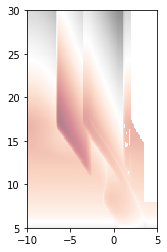

In [10]:
plt.imshow(Z, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
           cmap='RdGy', alpha=0.5)

In [11]:
case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
     name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_190820'
#name_ext += '_test'
np.shape(Z)
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'

    
np.savetxt(path, Z, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'


np.savetxt(path, X, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'


np.savetxt(path, Y, delimiter='\t', fmt='%.4e')



In [12]:
case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

In [13]:
NT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/E_gamma_nt.dat')
z_nt = NT[:,1]
E_nt = NT[:,0]

# f_nt = interp1d(z_nt,E_nt)


ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()
pi.set_dm_params_to_CT_pi_params(X_dm,ct)
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

G_nt = []
for zx in z_nt:
    G_nt.append(pi.find_Gamma_inj_for_injection_redshift_zX(zx,cosmo,ct))
G_nt = np.asarray(G_nt)

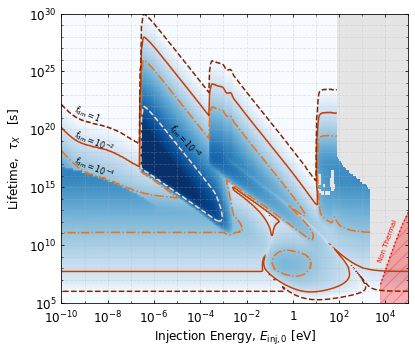

In [23]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5


tau_values = Yf[:,0]
Einj_values = Xf[0]

# tau_values = np.linspace(5,30,500)
# Einj_values =np.linspace(-10,5,500)

# tau_values = 10**Yf[0]
# Einj_values = 10**Xf[0]
# xlist = Einj_values
# ylist = tau_values

levels = [-8,-4,-2,0]

colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)

CS = ax.contour(Xf, Yf, Zf,levels,cmap = colormap,norm=normalize,linestyles=['--','-.','-','--'])


# CS.levels = [0.0001,0.01,1]


# # Label levels with specially formatted floats
# if plt.rcParams["text.usetex"]:
#     fmt = r'%r \%%'
# else:
#     fmt = r'$f_\mathrm{dm}=%r$'
    
# fmt = ticker.LogFormatterMathtext()

#ax.clabel(CS, CS.levels, inline=10, fontsize=8,fmt=fmt)
 

# masses_ev = np.logspace(-9,9,100)
# tau_dfsz = 1.1581e27*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_dfsz),c='k',lw=2,ls=':')
# tau_ksvz = 8.9078e23*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_ksvz),c='k',lw=2,ls=':')


ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


name_ext = ''

if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '.pdf'

ax.set_xlim(Einj_values[0],Einj_values[-1])
ax.set_ylim(tau_values[0],tau_values[-1])

ax.set_xlabel(label_injection_energy,size=title_size)
#ax.set_ylabel("coupling constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.11,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)


im = ax.imshow(Zf, extent=[-10,5,tau_values[0],tau_values[-1]], origin='lower',
           cmap=colormap2,norm=normalize, alpha=1.,aspect=0.5)


ax.text(0.03, 0.69, r'$f_\mathrm{dm}=1$' , rotation = -23,
        transform=ax.transAxes, fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(0.03, 0.61, r'$f_\mathrm{dm}=10^{-2}$' , rotation = -23,
        transform=ax.transAxes, fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(0.03, 0.52, r'$f_\mathrm{dm}=10^{-4}$' , rotation = -23,
        transform=ax.transAxes, fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))



ax.text(0.3, 0.63, r'$f_\mathrm{dm}=10^{-8}$' , rotation = -49,
        transform=ax.transAxes, fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(0.91, 0.29, r'Non Thermal' , rotation = 70,color='r',
        transform=ax.transAxes, fontsize=7, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))


ax.plot(np.log10(E_nt*1e3),np.log10(1./G_nt),c='red',ls=':')
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='r',alpha=0.3)
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='None',edgecolor='r')

ax.patch.set_color('grey') # or whatever color you like
ax.patch.set_alpha(.2)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$1$',r'$10^{2}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{5}$',r'$10^{10}$',r'$10^{15}$',r'$10^{20}$',r'$10^{25}$',r'$10^{30}$'])



fig.tight_layout()
#plt.legend()
plt.savefig(path_to_figures + '/figures_for_paper_tau_a' + name_ext)

In [9]:

def pi_run_fisher_constraints_on_given_spectrum(DI_array_in_Jy, x_array,f_ct,xinj_ct,*args,**kwargs):
    array_sum = np. sum(DI_array_in_Jy)
    if np.isnan(array_sum):
        f_dm = np.nan
    else:

        add_edges = kwargs.get('add_edges', 'no')


        firas = kwargs['firas']
        edges = kwargs['edges']


        T_pivot = 2.725
        sd.GetFirasXTatTpivot(firas,T_pivot)

        # photon_injection_case = 'lyc_reio'
        # add_edges = 'no'

        # sd_lib = sd_lib_lyc_reio
        #theory
        #parameters
        id_param = 0
        theta_parameters = []
        param_delta_T = 1.
        id_param_delta_T = id_param
        id_param += 1
        theta_parameters.append(param_delta_T)
        param_G0 = 1.
        id_param_G0 = id_param
        id_param += 1
        theta_parameters.append(param_G0)
        param_finj_over_fct = 1.
        id_param_finj_over_fct = id_param
        id_param += 1
        theta_parameters.append(param_finj_over_fct)

        M_parameters = len(theta_parameters)



        firas_delta_monopole = []
        firas_galaxy = []
        theory_photon_injection_spectrum = []

        for i in range(len(firas.firas_x)):
            nu = firas.firas_nu[i]
            firas_delta_monopole.append(sd.dB_nu_dT_at_T(nu,T_pivot))
            firas_galaxy.append(firas.firas_Gnu[i])

        covmat_data = firas.firas_covmat

        #Add edges_like point
        if add_edges=='yes':
            #edges = sd.edges()
            I_edges = sd.B_nu_of_T(edges.edges_nu,T_pivot)
            firas.firas_x = np.insert(firas.firas_x,0,edges.edges_x)
            firas_galaxy = np.insert(firas_galaxy,0,0.)
            firas_delta_monopole = np.insert(firas_delta_monopole,0,sd.dB_nu_dT_at_T(edges.edges_nu,T_pivot))
            cov_edges = [[(2.*I_edges)**2.]]
            covmat_data = block_diag(cov_edges, covmat_data)

        #covmat_data = np.diag(covmat_data)
        inv_covmat_data = np.linalg.inv(covmat_data)
        det_covmat_data = np.linalg.det(covmat_data)
        try:
            cholesky(covmat_data)
        except LinAlgError:
            raise ValueError("Covariance is not SPD!")


        x_asked = firas.firas_x
        # gamma_asked = 1e-8
        # Nx = 400
        # xi_array = np.logspace(-6,6,Nx)

        #Gamma_values = Gamma_inj_asked
        #gamma_labels = [r'$10^{-8}$',r'$10^{-9}$',r'$10^{-10}$',r'$10^{-11}$',r'$10^{-12}$',r'$10^{-13}$',r'$10^{-14}$',r'$10^{-15}$',r'$10^{-16}$',r'$10^{-17}$']


        f_dm_fisher = np.nan


        #mu_high_z = {}
        #mu_high_z['x'] = xi_array
        #mui = []
        #finji = []

        # evaluate spectrum at each data point
        f_Spectra = interp1d(x_array,DI_array_in_Jy)
        S = f_Spectra(x_asked)
        # convert to MJy
        theory_photon_injection_spectrum = S*1e-6 
        #print(S['DI'])


        mu_parameters = []
        mu_parameters.append(firas_delta_monopole)
        mu_parameters.append(firas_galaxy)
        mu_parameters.append(theory_photon_injection_spectrum)
        mu_parameters = np.asarray(mu_parameters)


        dmu_parameters = []
        for m in range(M_parameters):
            dmu_parameters.append(np.asarray(mu_parameters[m]))


        fisher_F = np.zeros((M_parameters,M_parameters))
        for a in range(M_parameters):
            for b in range(M_parameters):
                fisher_M_ab = np.outer(dmu_parameters[a],dmu_parameters[b]) + np.outer(dmu_parameters[b],dmu_parameters[a])
                fisher_F[a][b]=0.5*np.trace(np.matmul(inv_covmat_data,fisher_M_ab))

        inverse_fisher_F = np.linalg.inv(fisher_F)
        fisher_sigmas = []
        for m in range(M_parameters):
            fisher_sigmas.append(np.sqrt(inverse_fisher_F[m][m]))
        fisher_sigmas = np.asarray(fisher_sigmas)

        #mui.append(fisher_sigmas[id_param_finj_over_fct])
        r_finj_over_fct =  2.*fisher_sigmas[id_param_finj_over_fct]
        #print(r_finj_over_fct)
        #print(f_ct)
        #print(xinj_ct)
        f_dm = 1./1.3098e4*r_finj_over_fct*f_ct[0]*xinj_ct


        r_dict = {}
        r_dict['fisher_fdm'] = f_dm
        r_dict['fisher_finj'] = r_finj_over_fct*f_ct[0]

    return f_dm



In [10]:
def GetSpectra(Gamma_inj_asked,x_inj_asked,x_asked,specdist_ct_spectra_lib,get_fisher_fdm='no',use_edges='yes'):

    
    r1 = (Gamma_inj_asked - specdist_ct_spectra_lib.Gamma_inj_min)
    r2 = (specdist_ct_spectra_lib.Gamma_inj_max - Gamma_inj_asked)
    r3 = (x_inj_asked - specdist_ct_spectra_lib.x_inj_min)
    r4 = (specdist_ct_spectra_lib.x_inj_max - x_inj_asked)

    if (r1 < 0) or (r2 < 0) or (r3 < 0) or (r4 < 0):
        #print('filling with nans')
        array_x_asked =  np.empty(len(x_asked))
        array_x_asked[:] = np.nan
        array_S_result = np.empty(len(x_asked))
        array_S_result[:] =  np.nan
        F_gamma_asked_xinj_asked = np.nan
        fisher_fdm_2d_id_gamma_asked_xinj_asked =  np.nan

    else:
        X_2d =  specdist_ct_spectra_lib.X_2d
        DI_2d = specdist_ct_spectra_lib.DI_2d
        finj_2d = specdist_ct_spectra_lib.finj_2d

        Gamma_values = specdist_ct_spectra_lib.Gamma_values
        x_inj_values =  specdist_ct_spectra_lib.x_inj_values
        # print(Gamma_values)
        # print(x_inj_values)
        # print(find_nearests(Gamma_values, Gamma_inj_asked))
        id_gamma_low = find_nearests(Gamma_values, Gamma_inj_asked)[0]
        id_gamma_high = find_nearests(Gamma_values, Gamma_inj_asked)[1]

        id_xinj_low = find_nearests(x_inj_values, x_inj_asked)[0]
        id_xinj_high = find_nearests(x_inj_values, x_inj_asked)[1]

        #print(id_gamma_low,id_gamma_high,id_xinj_low,id_xinj_high)

        #DI_2d[id_gamma_low][id_xinj_low]  #DI_2d[id_gamma_low][id_xinj_high]
        #X_2d[id_gamma_low][id_xinj_low]   #X_2d[id_gamma_low][id_xinj_high]

        #DI_2d[id_gamma_high][id_xinj_low]  #DI_2d[id_gamma_high][id_xinj_high]
        #X_2d[id_gamma_high][id_xinj_low]   #X_2d[id_gamma_high][id_xinj_high]
        S = [[X_2d[id_gamma_low][id_xinj_low],DI_2d[id_gamma_low][id_xinj_low]],
             [X_2d[id_gamma_low][id_xinj_high],DI_2d[id_gamma_low][id_xinj_high]],
             [X_2d[id_gamma_high][id_xinj_low],DI_2d[id_gamma_high][id_xinj_low]],
             [X_2d[id_gamma_high][id_xinj_high],DI_2d[id_gamma_high][id_xinj_high]]]
        F = [finj_2d[id_gamma_low][id_xinj_low],finj_2d[id_gamma_low][id_xinj_high],finj_2d[id_gamma_high][id_xinj_low],finj_2d[id_gamma_high][id_xinj_high]]
        
        # if constraints are required, we need to evaluate the constraints 
        # at each of the nearest spectra, and then interpolate the fdm values
        
        if get_fisher_fdm == 'yes':
            fi = sd.firas()
            ed = sd.edges()
            a_dict = {}
            a_dict['firas'] = fi
            a_dict['edges'] = ed
            if use_edges == 'yes':
                a_dict['add_edges'] = 'yes'
            

            fisher_fdm_2d_id_gamma_low_xinj_low =  pi_run_fisher_constraints_on_given_spectrum(DI_2d[id_gamma_low][id_xinj_low],
                                                        X_2d[id_gamma_low][id_xinj_low],
                                                        finj_2d[id_gamma_low][id_xinj_low],
                                                        x_inj_values[id_xinj_low],
                                                        **a_dict)
            fisher_fdm_2d_id_gamma_low_xinj_high =  pi_run_fisher_constraints_on_given_spectrum(DI_2d[id_gamma_low][id_xinj_high],
                                                        X_2d[id_gamma_low][id_xinj_high],
                                                        finj_2d[id_gamma_low][id_xinj_high],
                                                        x_inj_values[id_xinj_high],
                                                        **a_dict)
            fisher_fdm_2d_id_gamma_high_xinj_low =  pi_run_fisher_constraints_on_given_spectrum(DI_2d[id_gamma_high][id_xinj_low],
                                                        X_2d[id_gamma_high][id_xinj_low],
                                                        finj_2d[id_gamma_high][id_xinj_low],
                                                        x_inj_values[id_xinj_low],
                                                        **a_dict)
            fisher_fdm_2d_id_gamma_high_xinj_high =  pi_run_fisher_constraints_on_given_spectrum(DI_2d[id_gamma_high][id_xinj_high],
                                                        X_2d[id_gamma_high][id_xinj_high],
                                                        finj_2d[id_gamma_high][id_xinj_high],
                                                        x_inj_values[id_xinj_high],
                                                        **a_dict)
            #(DI_array_in_Jy, x_array,f_ct,xinj_ct,*args,**kwargs)
       
        
        
            F_fdm_fisher = [fisher_fdm_2d_id_gamma_low_xinj_low,
                            fisher_fdm_2d_id_gamma_low_xinj_high,
                            fisher_fdm_2d_id_gamma_high_xinj_low,
                            fisher_fdm_2d_id_gamma_high_xinj_high]
            #print(F_fdm_fisher)
        
        dict = {
        "gamma_low": Gamma_values[id_gamma_low],
        "gamma_high": Gamma_values[id_gamma_high],
        "xinj_low": x_inj_values[id_xinj_low],
        "xinj_high": x_inj_values[id_xinj_high],
        "spectra": S,
        "finj": F,
        "fisher_fdm": F_fdm_fisher
        }

        #print(F)
        #### start interpolation

        gamma_low = dict["gamma_low"]
        gamma_high = dict["gamma_high"]
        xinj_low = dict["xinj_low"]
        xinj_high = dict["xinj_high"]
        S = dict["spectra"]
        F = dict["finj"]

        #print(gamma_low)
        #print(gamma_high)

        S_gamma_low_xinj_low = S[0]
        S_gamma_low_xinj_high = S[1]
        S_gamma_high_xinj_low = S[2]
        S_gamma_high_xinj_high = S[3]

        F_gamma_low_xinj_low = F[0][0]
        F_gamma_low_xinj_high = F[1][0]
        F_gamma_high_xinj_low = F[2][0]
        F_gamma_high_xinj_high = F[3][0]

        Gamma_asked = Gamma_inj_asked
        xinj_asked = x_inj_asked

        #check if nan in any of the arrays:
        Arrays_list = [S_gamma_low_xinj_low,
                      S_gamma_low_xinj_high,
                      S_gamma_high_xinj_low,
                      S_gamma_high_xinj_high]
        has_nan = False
        for p in Arrays_list:
            array = p
            array_sum = np.sum(np.sum(array))
            has_nan += np.isnan(array_sum)
        if np.sum(has_nan):
            #print('filling with nans')
            array_x_asked =  np.empty(len(x_asked))
            array_x_asked[:] = np.nan
            array_S_result = np.empty(len(x_asked))
            array_S_result[:] =  np.nan
            F_gamma_asked_xinj_asked = np.nan
            fisher_fdm_2d_id_gamma_asked_xinj_asked = np.nan
        else:
            nx = int(1e4)


            ############### xinj_low
            new_x_min = np.maximum(np.min(S_gamma_low_xinj_low[0]),np.min(S_gamma_high_xinj_low[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_low[0]),np.max(S_gamma_high_xinj_low[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]


            f_gamma_low = interp1d(S_gamma_low_xinj_low[0], S_gamma_low_xinj_low[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_low[0], S_gamma_high_xinj_low[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _low : w_gamma = %.14e'%w)



            S_gamma_asked_xinj_low = [[],[]]
            S_gamma_asked_xinj_low[0] = new_x_array
            S_gamma_asked_xinj_low[1] = new_S_gamma_asked

            F_gamma_asked_xinj_low = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_low
            
            fisher_fdm_2d_id_gamma_asked_xinj_low = w*fisher_fdm_2d_id_gamma_low_xinj_low + (1.-w)*fisher_fdm_2d_id_gamma_high_xinj_low

            ############# xinj_high

            new_x_min = np.maximum(np.min(S_gamma_low_xinj_high[0]),np.min(S_gamma_high_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_high[0]),np.max(S_gamma_high_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_gamma_low = interp1d(S_gamma_low_xinj_high[0], S_gamma_low_xinj_high[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_high[0], S_gamma_high_xinj_high[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
#             #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
#             w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _high : w_gamma = %.14e'%w)

            S_gamma_asked_xinj_high = [[],[]]
            S_gamma_asked_xinj_high[0] = new_x_array
            S_gamma_asked_xinj_high[1] = new_S_gamma_asked

            F_gamma_asked_xinj_high = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_high
            fisher_fdm_2d_id_gamma_asked_xinj_high = w*fisher_fdm_2d_id_gamma_low_xinj_low + (1.-w)*fisher_fdm_2d_id_gamma_high_xinj_high


            ############# interpolation between xinjs
            new_x_min = np.maximum(np.min(S_gamma_asked_xinj_low[0]),np.min(S_gamma_asked_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_asked_xinj_low[0]),np.max(S_gamma_asked_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_xinj_low = interp1d(S_gamma_asked_xinj_low[0], S_gamma_asked_xinj_low[1])
            f_xinj_high = interp1d(S_gamma_asked_xinj_high[0], S_gamma_asked_xinj_high[1])

            new_S_xinj_low = f_xinj_low(new_x_array)
            new_S_xinj_high = f_xinj_high(new_x_array)

            #w = (xinj_high - xinj_asked)/(xinj_high - xinj_low)
            w = (np.log(xinj_high) - np.log(xinj_asked))/(np.log(xinj_high) - np.log(xinj_low))
#             print('xinj_high = %.14e'%xinj_high)
#             print('w_xinj = %.14e'%w)

            new_S_xinj_asked = w*new_S_xinj_low + (1.-w)*new_S_xinj_high

            S_gamma_asked_xinj_asked = [[],[]]
            S_gamma_asked_xinj_asked[0] = new_x_array
            S_gamma_asked_xinj_asked[1] = new_S_xinj_asked

            F_gamma_asked_xinj_asked = w*F_gamma_asked_xinj_low + (1.-w)*F_gamma_asked_xinj_high
            fisher_fdm_2d_id_gamma_asked_xinj_asked = w*fisher_fdm_2d_id_gamma_asked_xinj_low + (1.-w)*fisher_fdm_2d_id_gamma_asked_xinj_high




            f_gamma_asked_xinj_asked = interp1d(S_gamma_asked_xinj_asked[0], S_gamma_asked_xinj_asked[1])
            ########### get spectra at required x values
            bound_x_min = np.min(S_gamma_asked_xinj_asked[0])
            bound_x_max = np.max(S_gamma_asked_xinj_asked[0])

            array_x_asked = np.asarray(x_asked)

            min_x_asked = np.min(array_x_asked)
            max_x_asked = np.max(array_x_asked)

            id_min = 0
            id_max = None
            if min_x_asked < bound_x_min:
                id_min = find_nearests(array_x_asked, bound_x_min)[1]
            if max_x_asked > bound_x_max:
                id_max = find_nearests(array_x_asked, bound_x_max)[0]
            array_x_asked = array_x_asked[id_min:id_max]

            array_S_result = f_gamma_asked_xinj_asked(array_x_asked)

    # return spectra in Jy/sr for specific value of finj
    #print(fisher_fdm_2d_id_gamma_asked_xinj_asked)
    r_dict = {"x":array_x_asked,
              "DI": array_S_result,
              "finj": F_gamma_asked_xinj_asked,
              "fisher_fdm": fisher_fdm_2d_id_gamma_asked_xinj_asked}

    return r_dict

In [5]:
gamma_asked = 1e-15
x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
nx = 1
colors = iter(cm.rainbow(np.linspace(0, 1, nx)))
for xinj in np.logspace(-8,7,nx):
    col = next(colors)
    S_xe_history = sd.GetSpectra(gamma_asked,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    plt.plot(S_xe_history['x'],np.abs(S_xe_history['DI']),label=r'$x_{inj}=%.3e$'%xinj,c=col)
    #plt.plot(S_xe_history['z'],np.abs(S_xe_history['Xe_no_inj']),c=col,ls='--')
plt.loglog()
plt.legend(loc=3)
plt.ylim(1e-8,1e10)
plt.grid(which='both')
plt.xlabel(r'$z$')
plt.ylabel(r'$DI$')
plt.title('Gamma=1e-15')
#plt.savefig(path_to_figures + 'pca_new_code_DI_vs_x.pdf')

TypeError: GetSpectra() got an unexpected keyword argument 'get_fisher_fdm'

In [34]:
sd_lib = sd_lib_extended_run

firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'yes'
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 1e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 0
rf.rf_Reionization_model = 1
rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422

a_dict['recfast'] = rf
a_dict['sd_lib'] = sd_lib
fdm_fisher = []
fdm_pca_rf = []
fdm_pca_ct = []

Nx = 200
xi_array = np.logspace(-6,7,Nx)

for gamma in [1e-17]:
    print(gamma)
    for xinj in xi_array:
        #print(xinj)
    #    f_dm_fisher = sd.pi_run_fisher_constraints([gamma],[xinj],**a_dict)
    #    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #    print(fdm_value)
    #    f_dm_pca = pi_run_pca_constraints_with_recfast([xinj],[gamma],fdm_value,**a_dict)
    #    fdm_pca_value = f_dm_pca['curves'][0]['fdm'][0]
    #    print(fdm_pca_value)
    
        fdm_results = get_fdm_constraints_at_Gamma_and_xinj(gamma,xinj,**a_dict)
        fdm_fisher.append(fdm_results['fdm_fisher'])
        fdm_pca_rf.append(fdm_results['fdm_Xe_pca_rf'])
        fdm_pca_ct.append(fdm_results['fdm_Xe_pca_ct'])
fdm_fisher = np.asarray(fdm_fisher)
fdm_pca_rf = np.asarray(fdm_pca_rf)
fdm_pca_ct = np.asarray(fdm_pca_ct)



1e-17


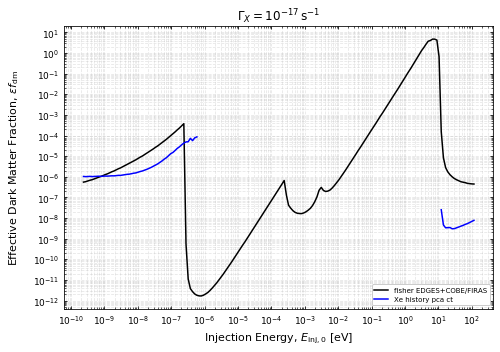

In [35]:
#photon_injection_case = 'lyc_reio'

fig, (ax1) = plt.subplots(1,1,figsize=(7,5))
ax = ax1
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_fdm,size=title_size)
ax.set_xlabel(label_injection_energy,size=title_size)
ax.yaxis.set_label_coords(-.10,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.plot(xinj_to_Einj*xi_array,np.abs(fdm_fisher),c='k',label='fisher EDGES+COBE/FIRAS',ls='-', marker='None')
#ax.plot(xinj_to_Einj*xi_array,fdm_pca_rf,c='r',label='Xe history pca rf',ls='-', marker='o')
ax.plot(xinj_to_Einj*xi_array,fdm_pca_ct,c='b',label='Xe history pca ct',ls='-', marker='None')

plt.title(r'$\Gamma_X=$'+scientific_notation(gamma)+r'$\,\mathrm{s^{-1}}$')

ax.legend(loc=4,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
str_gamma = '%.4e'%gamma
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_pca_edges_G_'+str_gamma+'.pdf')
plt.show()
plt.close(fig)

In [14]:
fdm_fisher

array([ 5.07519436e-07,  5.07439250e-07,  5.07470073e-07,  5.07455742e-07,
        5.07443808e-07,  5.07438843e-07,  5.07465904e-07,  5.07454523e-07,
        5.07486472e-07,  5.07470351e-07,  5.07398378e-07,  5.07465630e-07,
        5.07434255e-07,  5.07556158e-07,  5.07658073e-07,  5.07571820e-07,
        5.07372795e-07,  5.07444846e-07,  5.07590965e-07,  5.07729435e-07,
        5.07853051e-07,  5.08036562e-07,  5.08321713e-07,  5.08848730e-07,
        5.09839785e-07,  5.11280643e-07,  5.13614868e-07,  5.16851881e-07,
        5.13698873e-07,  5.08394676e-07,  2.27259452e-06,  3.26879109e-06,
        4.38517978e-06,  5.12699618e-06,  5.82971489e-06,  6.43785793e-06,
        7.03326318e-06,  7.65526633e-06,  8.34087363e-06,  9.11551868e-06,
        1.00078421e-05,  1.09702091e-05,  1.21482364e-05,  1.34859071e-05,
        1.49995779e-05,  1.67088336e-05,  1.86451096e-05,  2.08431252e-05,
        2.33427648e-05,  2.61792918e-05,  2.94099130e-05,  3.28775395e-05,
        3.71073498e-05,  

In [5]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_with_collision_20x20_170820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_5e-6_no_collision_160820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [3]:
sd_lib_extended_run.Gamma_values

array([1.00000000e-20, 1.41872667e-20, 2.01278538e-20, 2.85559230e-20,
       4.05130497e-20, 5.74769442e-20, 8.15440740e-20, 1.15688753e-19,
       1.64130720e-19, 2.32856630e-19, 3.30359912e-19, 4.68690419e-19,
       6.64943600e-19, 9.43373222e-19, 1.33838875e-18, 1.89880782e-18,
       2.69388931e-18, 3.82189262e-18, 5.42222101e-18, 7.69264957e-18,
       1.09137671e-17, 1.54836526e-17, 2.19670709e-17, 3.11652694e-17,
       4.42149991e-17, 6.27289986e-17, 8.89953035e-17, 1.26260011e-16,
       1.79128445e-16, 2.54134304e-16, 3.60547115e-16, 5.11517810e-16,
       7.25703961e-16, 1.02957557e-15, 1.46068632e-15, 2.07231465e-15,
       2.94004806e-15, 4.17112461e-15, 5.91768575e-15, 8.39557862e-15,
       1.19110313e-14, 1.68984979e-14, 2.39743497e-14, 3.40130494e-14,
       4.82552204e-14, 6.84609684e-14, 9.71274020e-14, 1.37797236e-13,
       1.95496614e-13, 2.77356261e-13, 3.93492726e-13, 5.58258627e-13,
       7.92016405e-13, 1.12365480e-12, 1.59415904e-12, 2.26167595e-12,
      

1e-20
1.418726674116599e-20


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '3', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-vcodec', 'libx264', '-y', '/Users/boris/Work/SPECTRAL-DISTORTIONS/figures//DI_extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_190820_G_1.4187e-20_with_coll.mp4']' returned non-zero exit status 255.

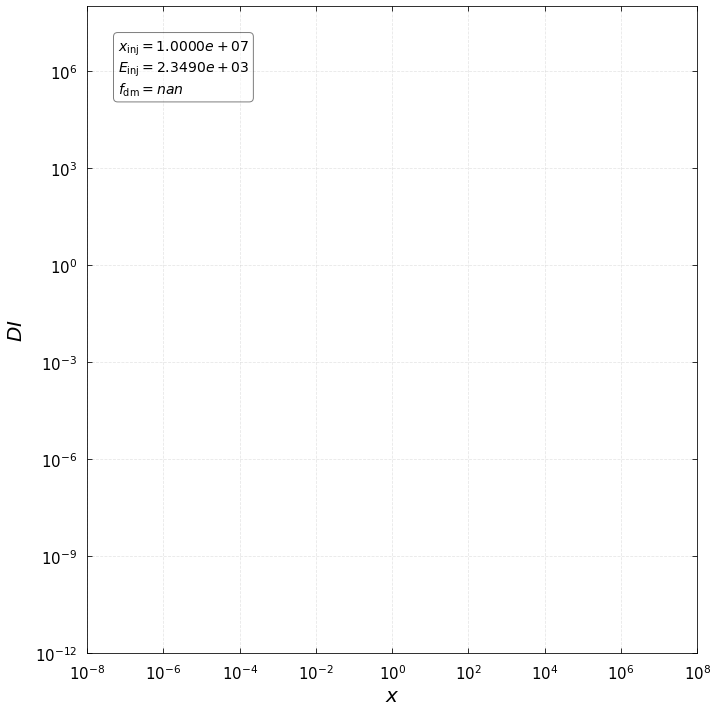

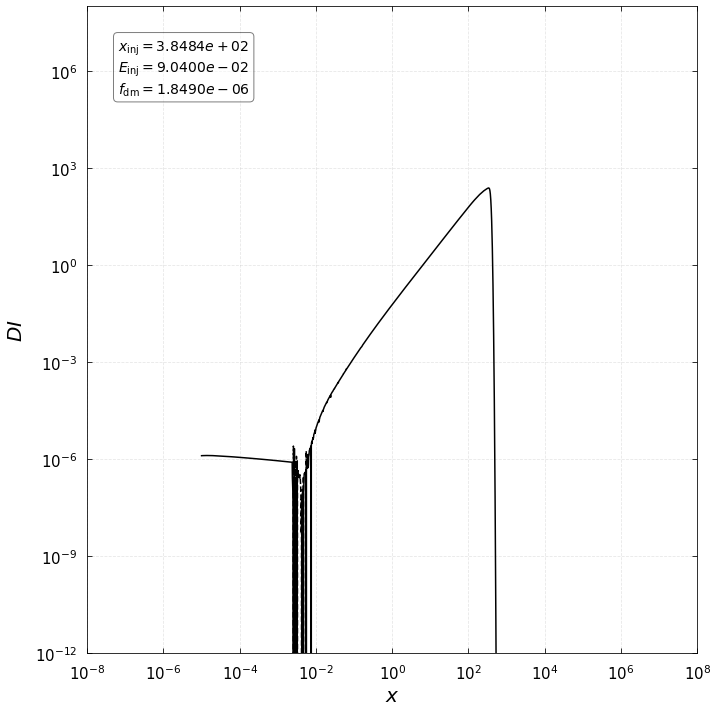

In [4]:
#i = 46
i=0
for gamma_asked in sd_lib_extended_run.Gamma_values:
    nx = len(sd_lib_extended_run.x_inj_values)
    x = []
    y = []
    xinj = []
    fdm_values = []
    #z_asked = np.logspace(-2,5,1e3)
    for k in range(nx):
        xinj.append(sd_lib_extended_run.x_inj_values[k])
        #S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
        x.append(sd_lib_extended_run.X_2d[i][k])
        y.append(sd_lib_extended_run.DI_2d[i][k])
        fdm_values.append(sd_lib_extended_run.finj_2d[i][k][0]/1.3098e4*sd_lib_extended_run.x_inj_values[k])
    print(gamma_asked)


    #xinj = np.logspace(-8,7,nx)
    x_min = 1.e-8
    x_max = 1.e8
    #raise

    fig, ax1 = plt.subplots(1,1,figsize=(10,10))
    label_size = 15
    title_size = 20
    legend_size = 25
    handle_length = 1.5

    ymin = 1.e-12
    ymax = 1e8


    linesp = []
    patches = []


    i_ax = 0



    for ax in [ax1]:
        ax.set_xlim(x_min,x_max)
        ax.set_ylim(ymin,ymax)
        ax.set_xscale('log')
        ax.set_yscale('log')


        #ax.set_xlabel("scaled injection frequency, "+ r'$x_\mathrm{inj}=h\nu_\mathrm{inj}/k_{_\mathrm{B}}T_{\gamma}$',size=title_size)
        ax.set_xlabel(r'$x$',size=title_size)
        ax.set_ylabel(r'$DI$',size=title_size)
        ax.yaxis.set_label_coords(-.1,0.5)

        # ticks_array = np.logspace(-6,6,13)
        # ax.set_xticks(ticks_array)

        # ticks_array = np.logspace(-8,2,11)
        # ax.set_yticks(ticks_array)


        ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
        ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

        plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
        plt.setp(ax.get_xticklabels(), fontsize=label_size)

        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')



        plt.grid( b=True, which="both", alpha=0.3, linestyle='--')

        i_ax = i_ax + 1


    linesp1 = [ax1.plot([], [],c='k',ls='-')[0] for _ in range(1)]
    linesm1 = [ax1.plot([], [],c='k',ls='--')[0] for _ in range(1)]
    text_gamma =  [ax.text(0.05, 0.15, r'$x_\mathrm{inj}= %.4e$'%1, transform=ax.transAxes, fontsize=14, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))]
    patches1 = linesp1 + linesm1 + text_gamma 


    patches = patches1




    def init():

        for line in linesp1:
            line.set_data([], [])
        for line in linesm1:
            line.set_data([], [])

        return patches

    def animate(i):
        for j,line in enumerate(linesm1):
            if j==0:
                line.set_data(x[i],-y[i])
        for j,line in enumerate(linesp1):
            if j==0:
                line.set_data(x[i],y[i])
            text_gamma[j].remove()
            einj = xinj_to_Einj*xinj[i]
            text_gamma_str1 = r'$x_\mathrm{inj}= %.4e$'%xinj[i]
            text_gamma_str2 = r'$E_\mathrm{inj}= %.4e$'%einj
            text_gamma_str3 = r'$f_\mathrm{dm}= %.4e$'%fdm_values[i]
            text_gamma_str = '\n'.join((text_gamma_str1,text_gamma_str2,text_gamma_str3))
            text_gamma[j] = ax.text(0.05, 0.95, text_gamma_str , transform=ax.transAxes, fontsize=14, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        return patches


    fig.tight_layout()





    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(y), interval=800, blit=True)

    anim.save(path_to_figures + '/DI_extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_190820_G_'+'%.4e'%gamma_asked+'_with_coll.mp4', fps=3, extra_args=['-vcodec', 'libx264'],dpi=100)
    #plt.show()
    i+=1

1e-08
2.335721469090121e-09
5.455594781168515e-10
1.274274985703132e-10
2.976351441631313e-11
6.951927961775591e-12
1.6237767391887243e-12
3.7926901907322537e-13
8.858667904100832e-14
2.06913808111479e-14
4.8329302385717525e-15
1.128837891684693e-15
2.6366508987303663e-16
6.15848211066028e-17
1.4384498882876658e-17
3.359818286283788e-18
7.847599703514623e-19
1.8329807108324374e-19
4.281332398719396e-20
1e-20
1e-21
1e-22
1e-23
1e-24
1e-25
1e-26
1e-27
1e-28
1e-29
1e-30


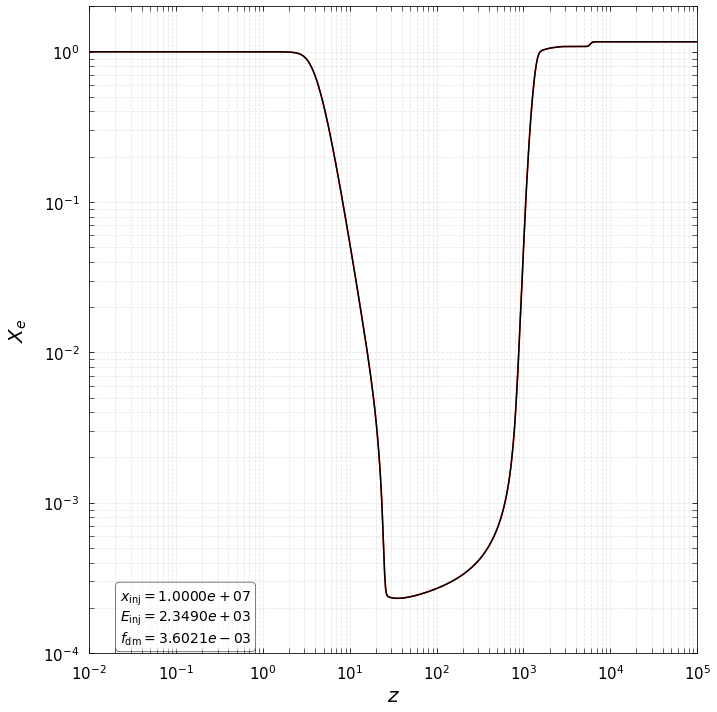

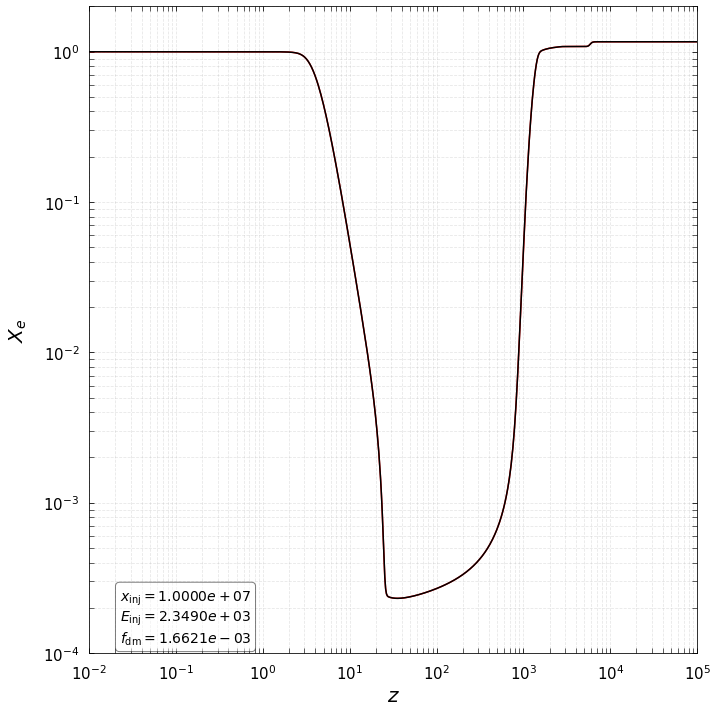

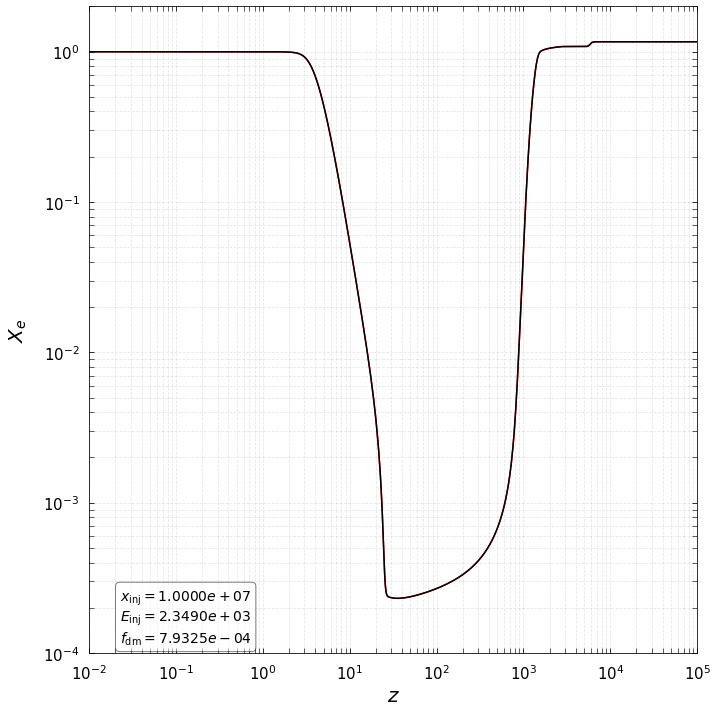

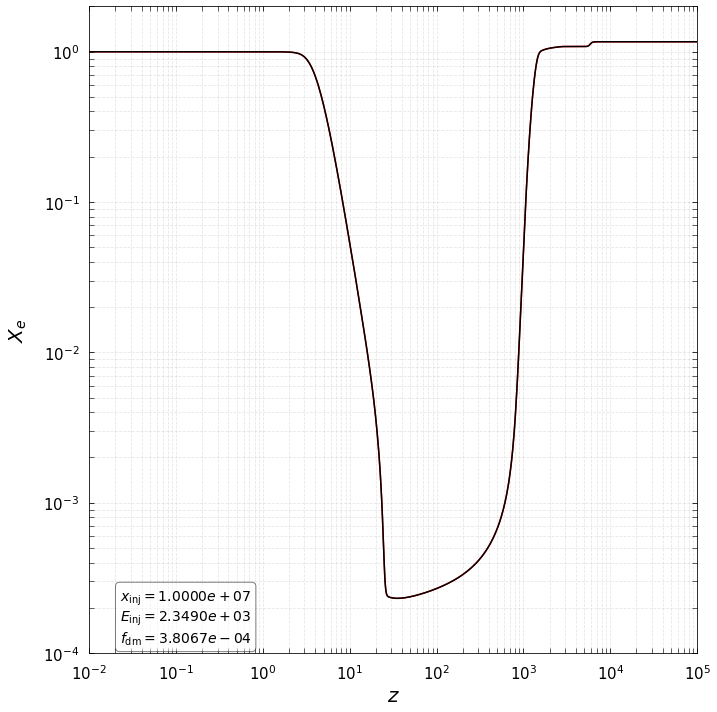

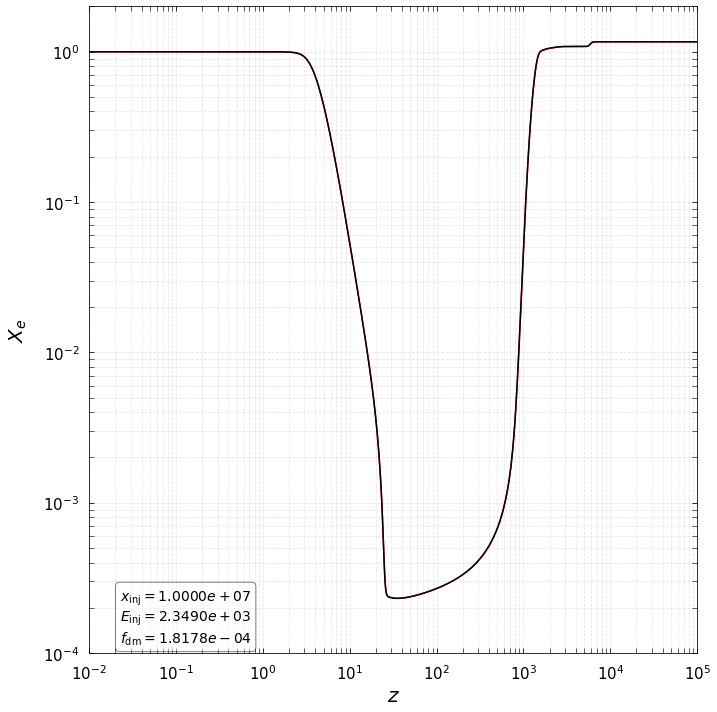

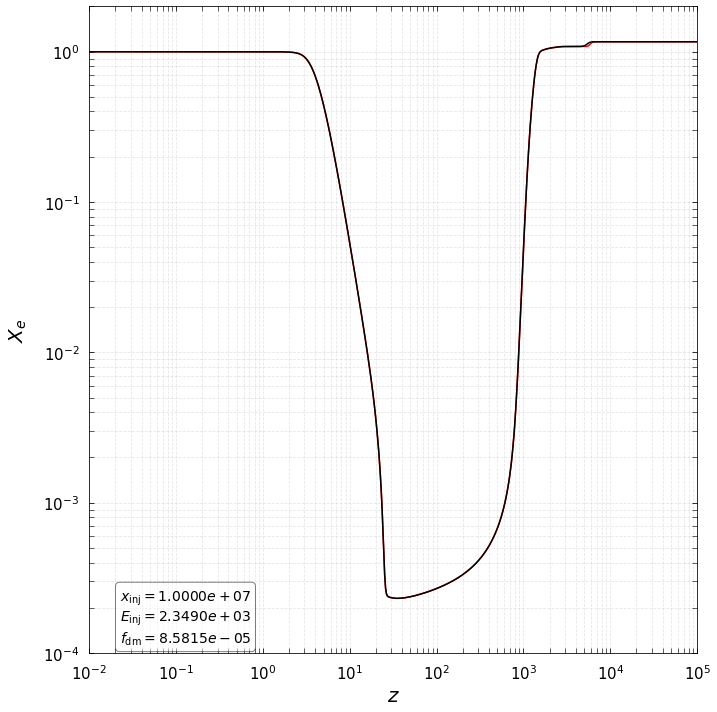

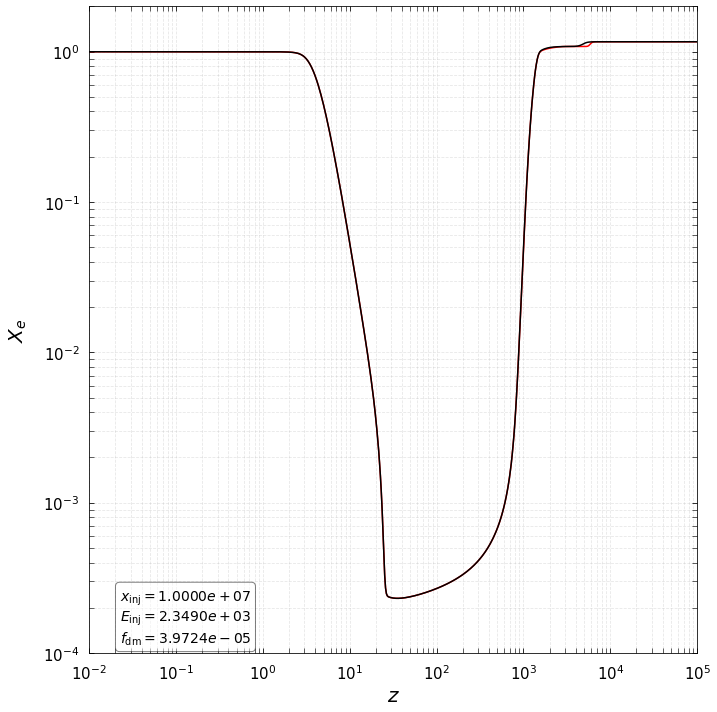

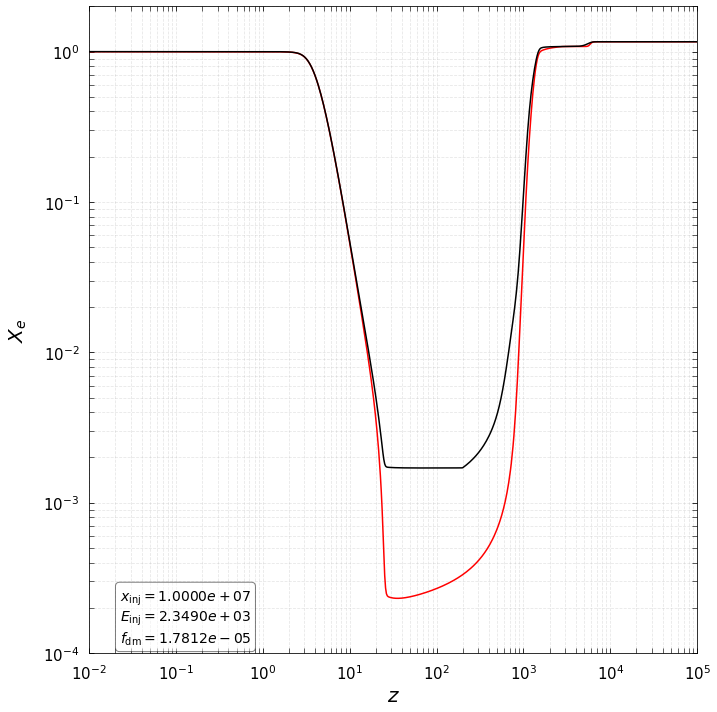

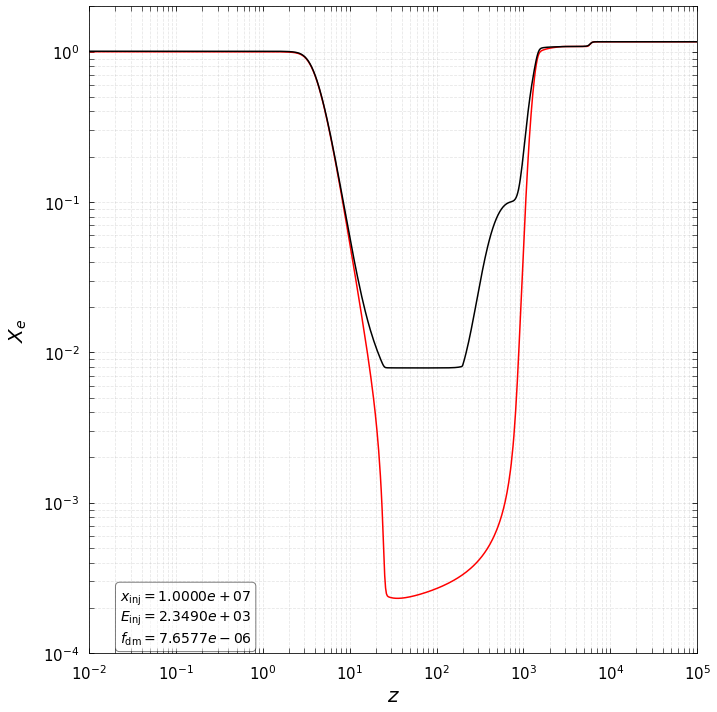

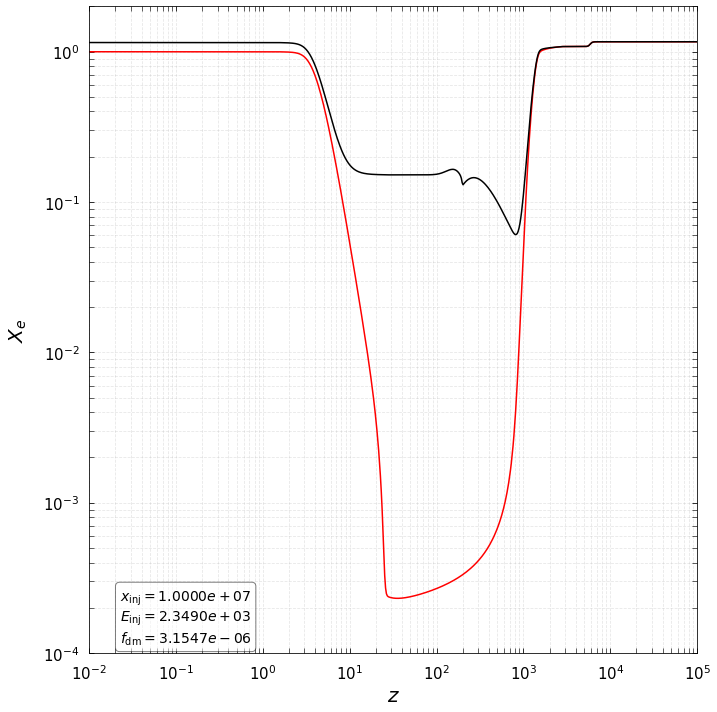

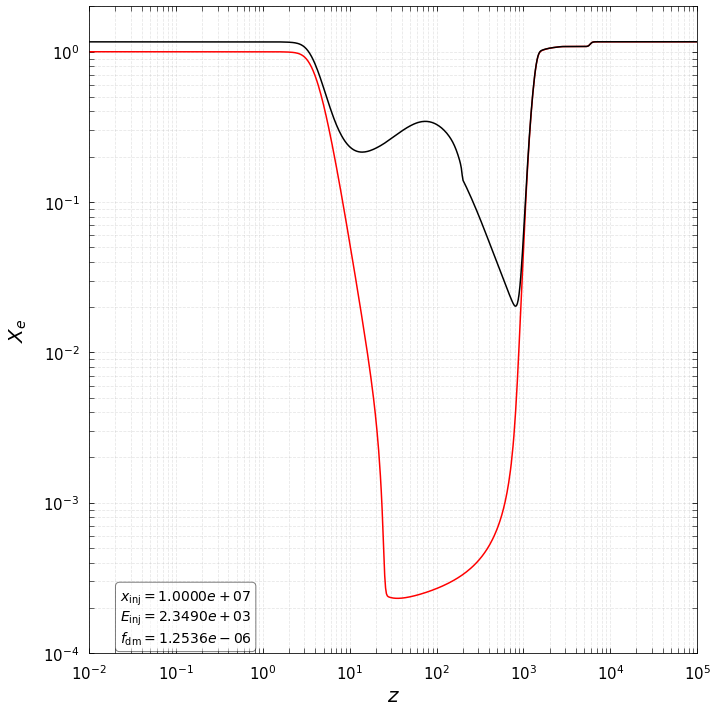

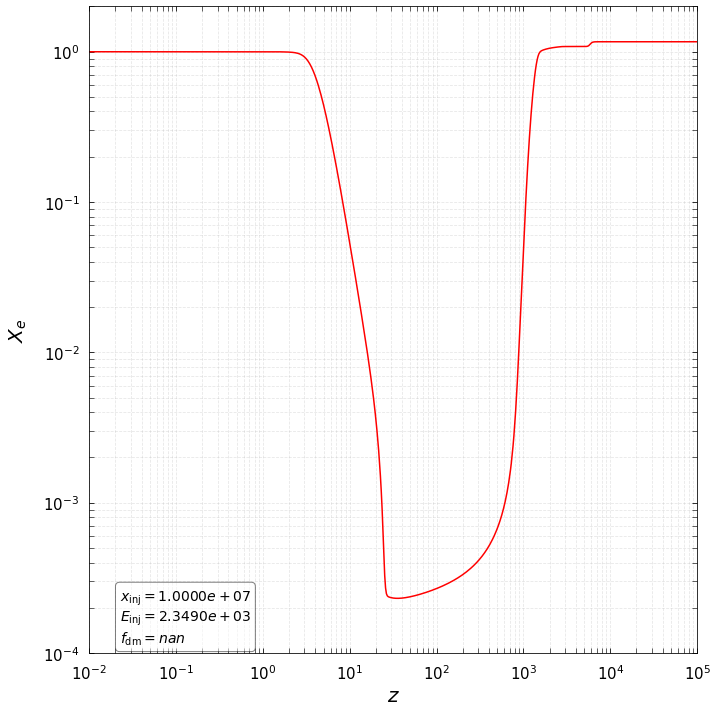

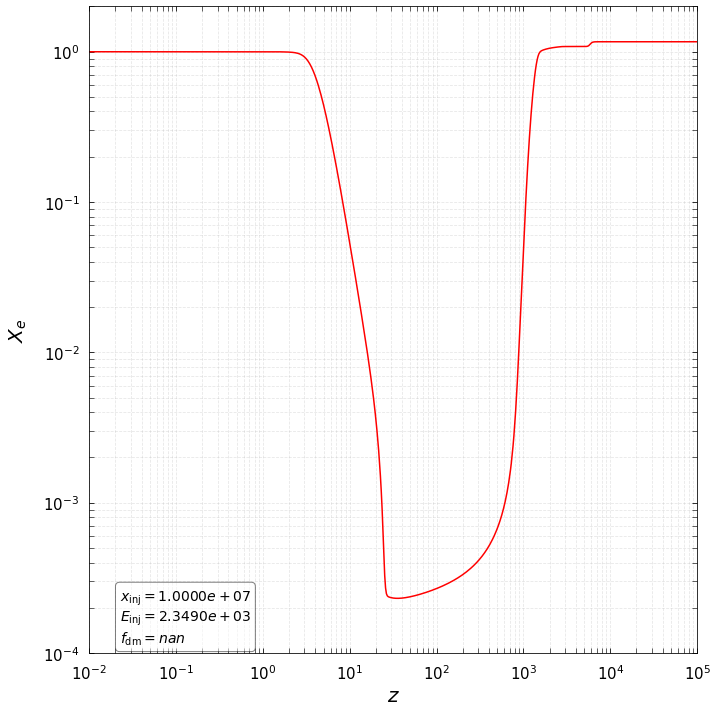

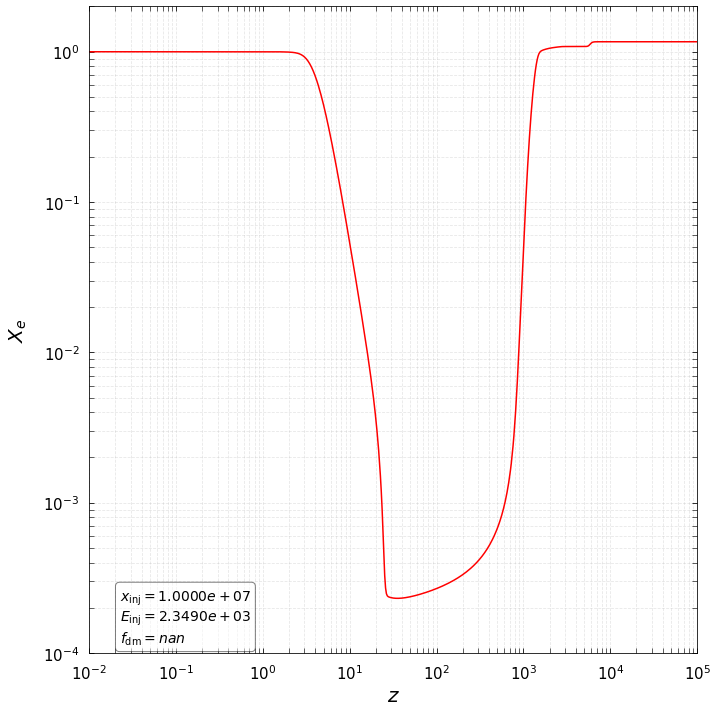

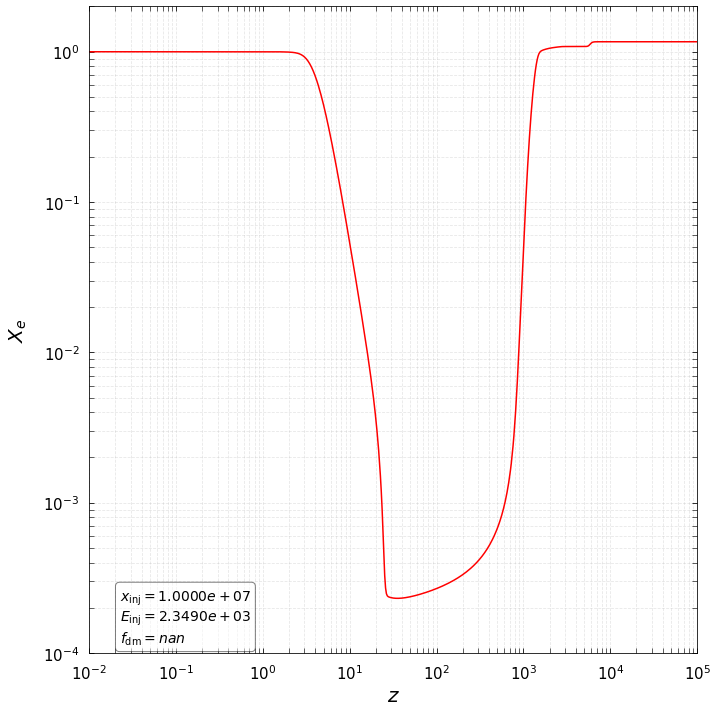

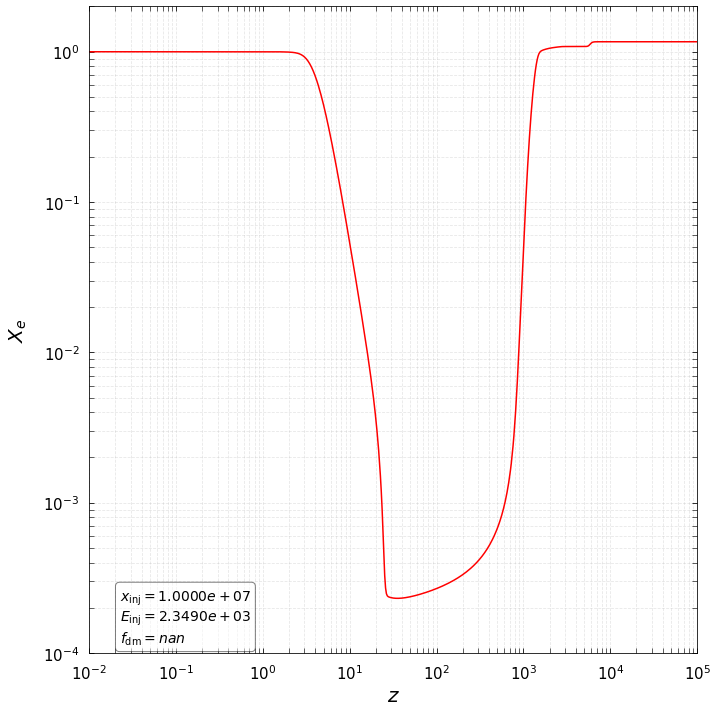

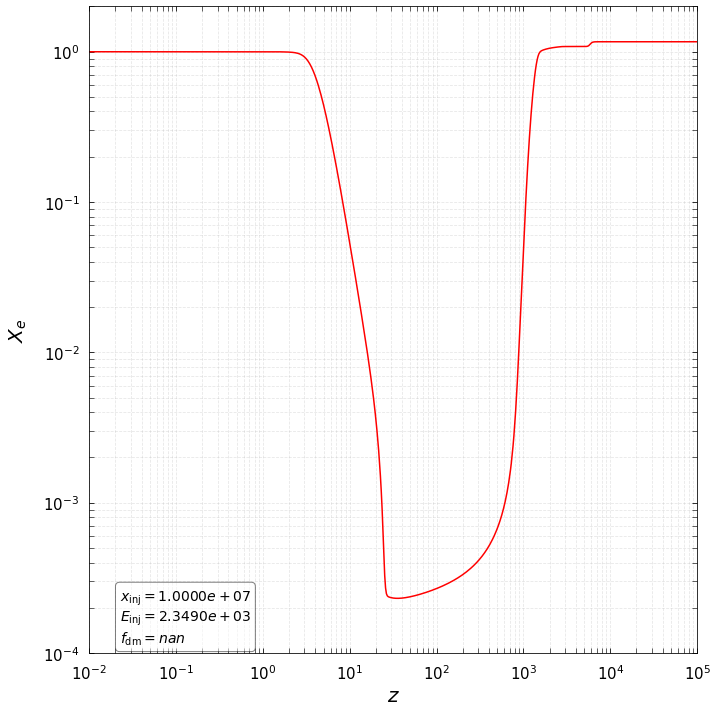

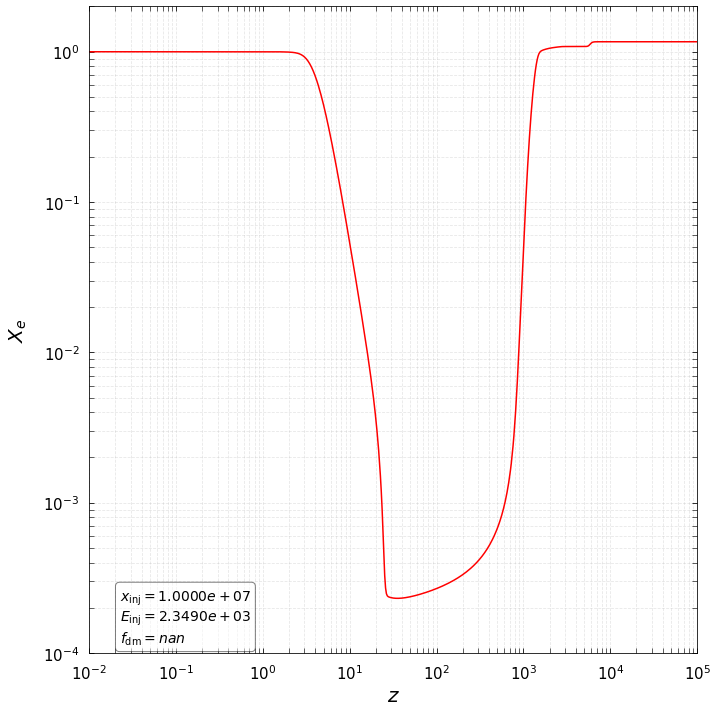

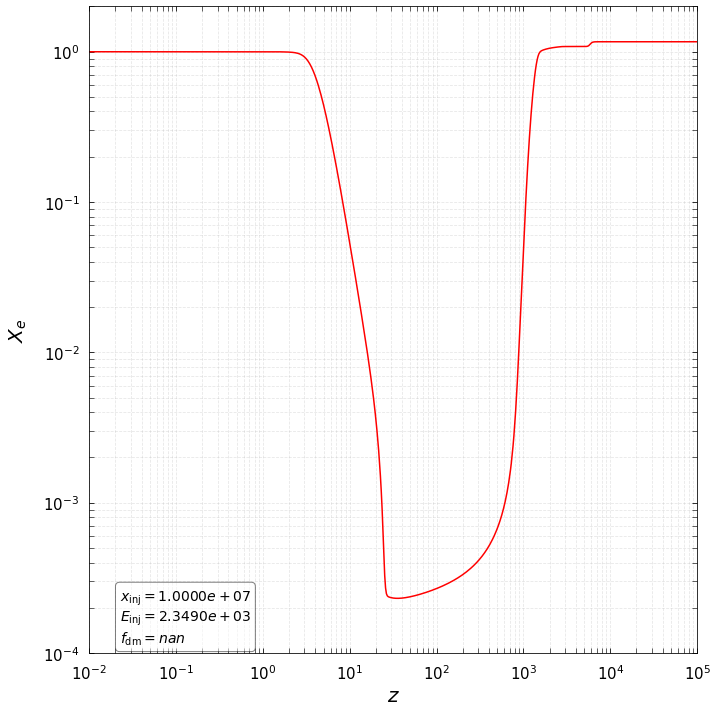

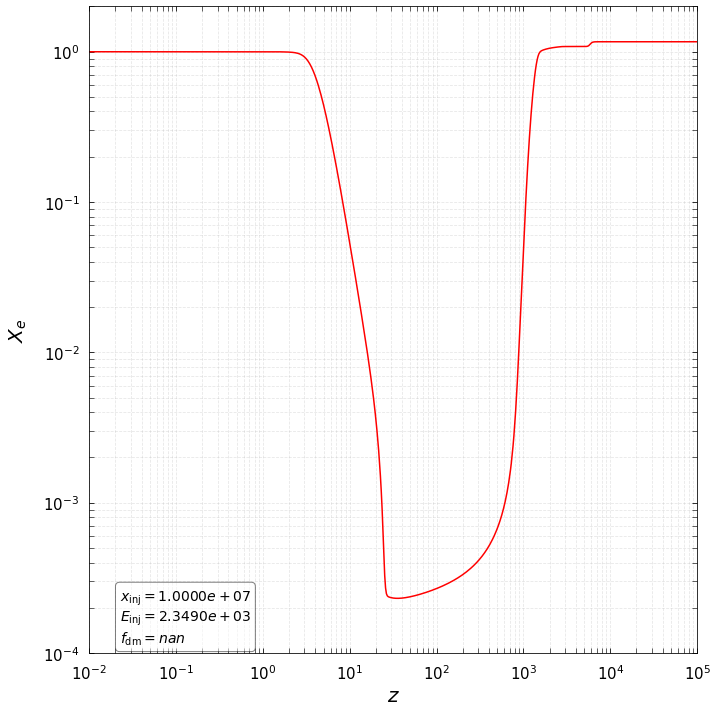

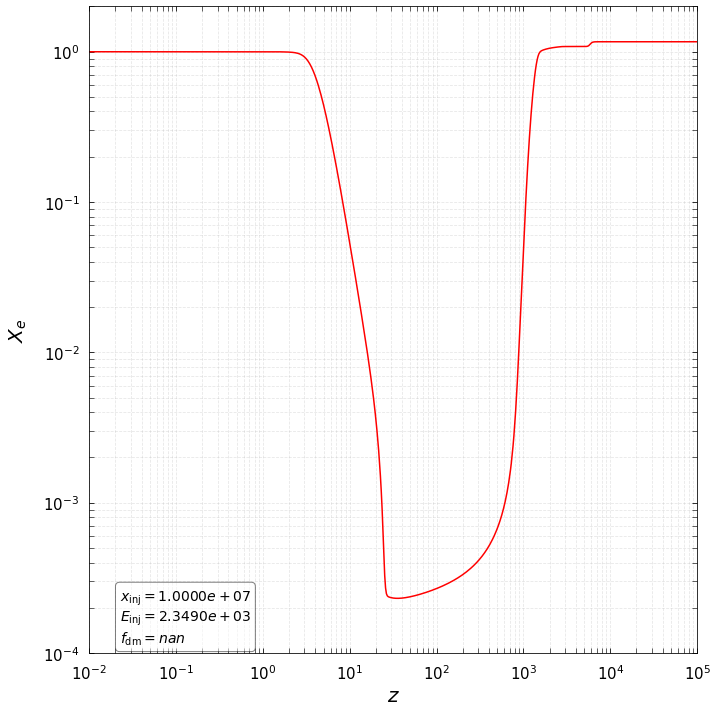

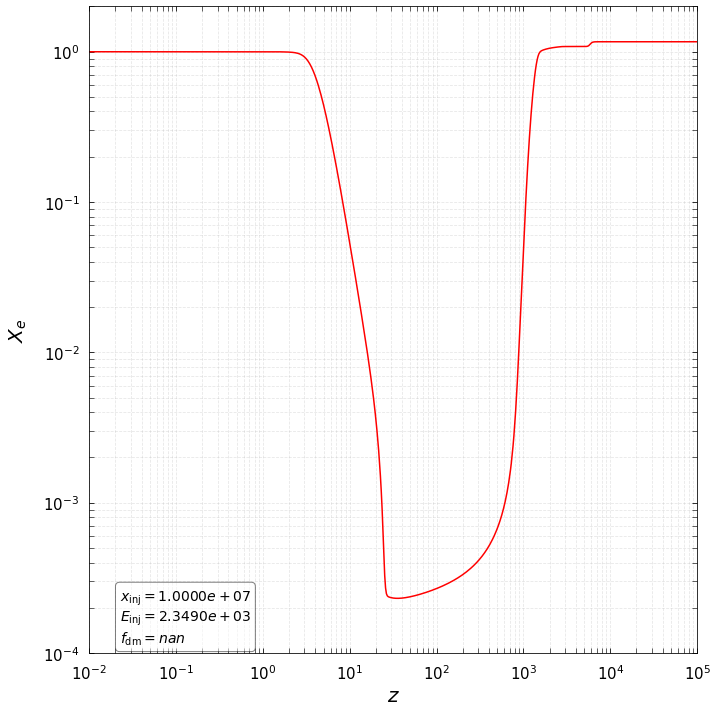

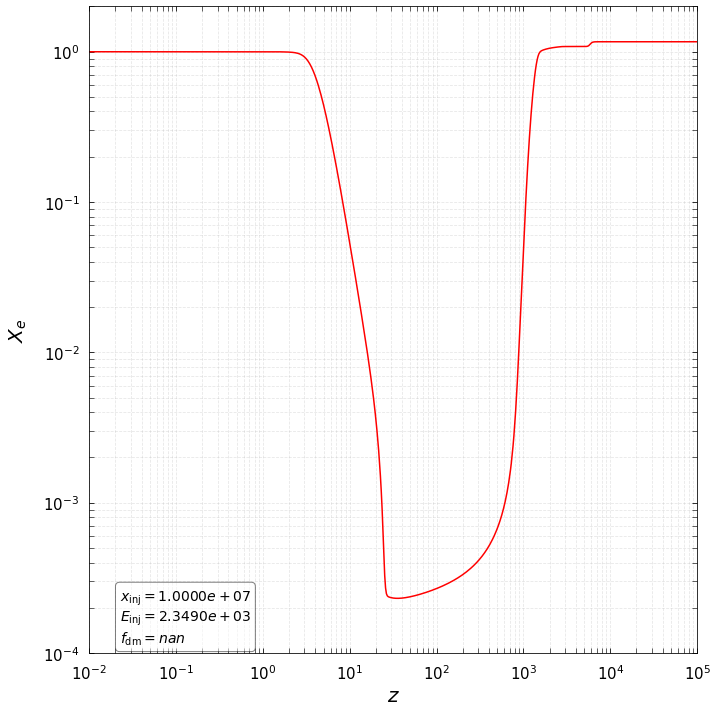

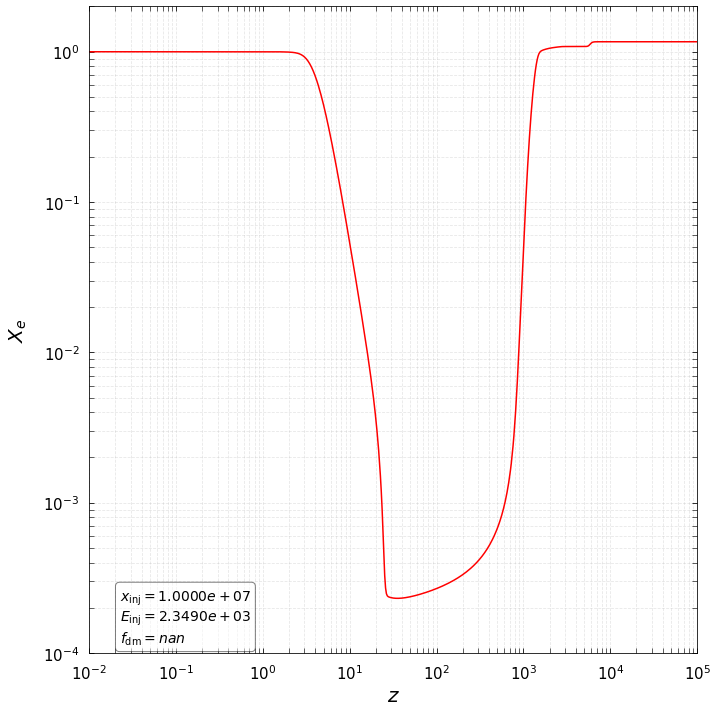

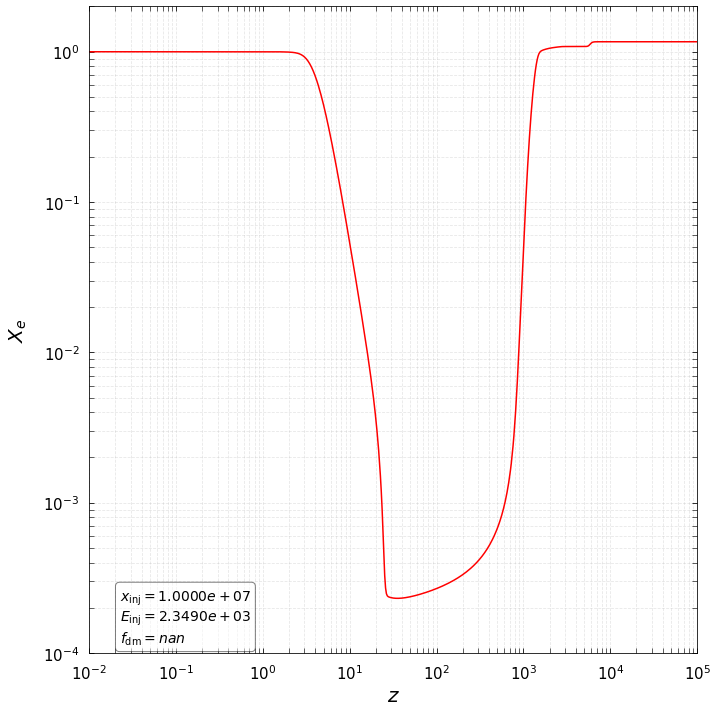

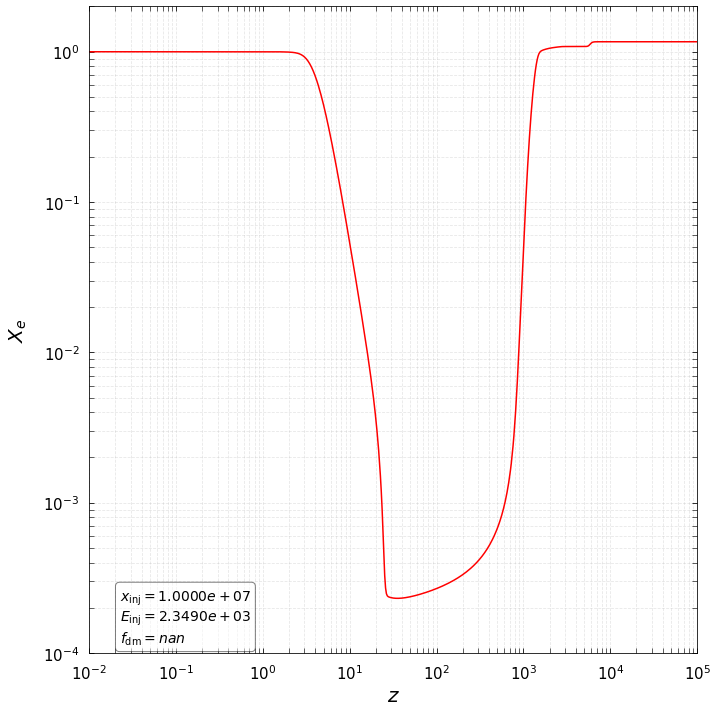

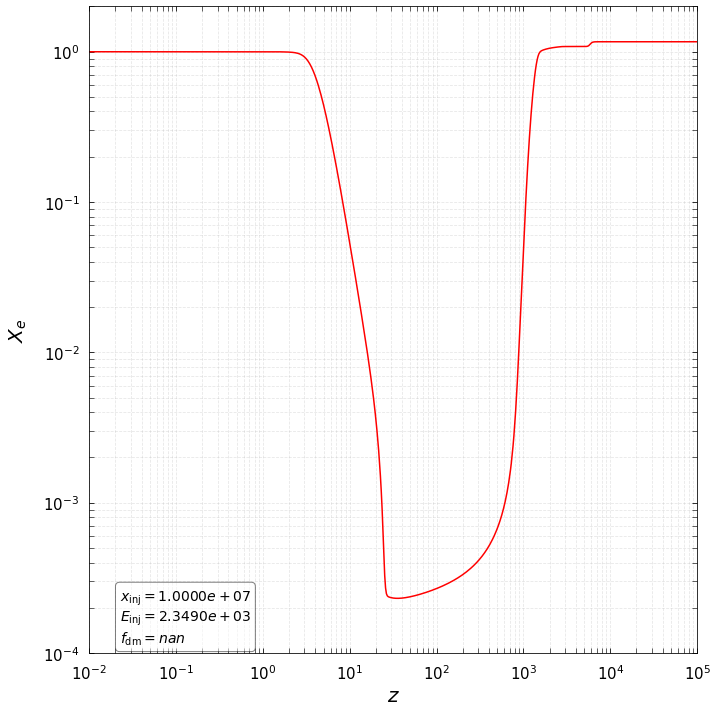

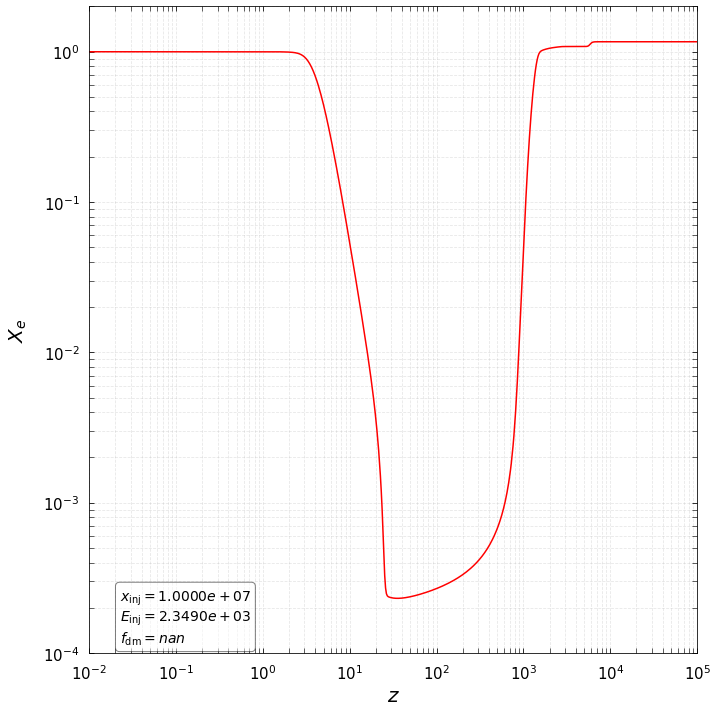

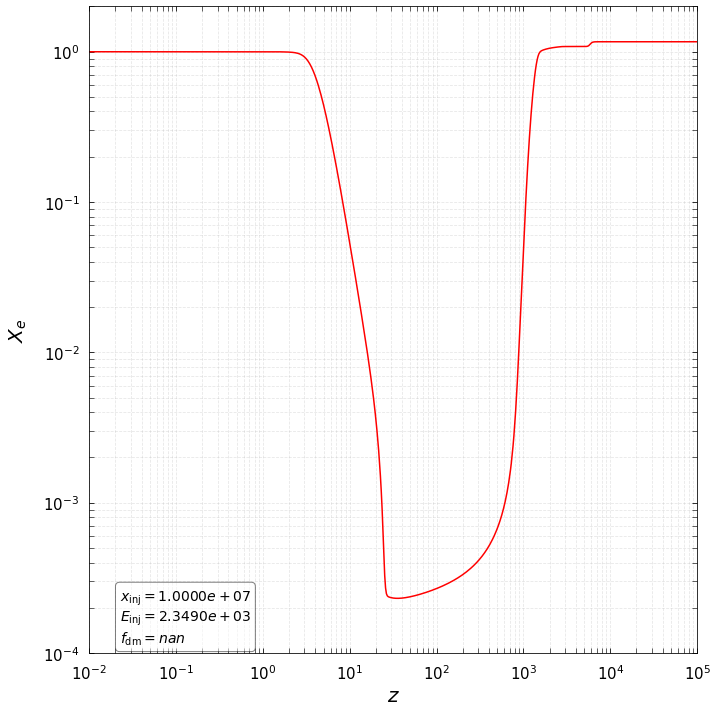

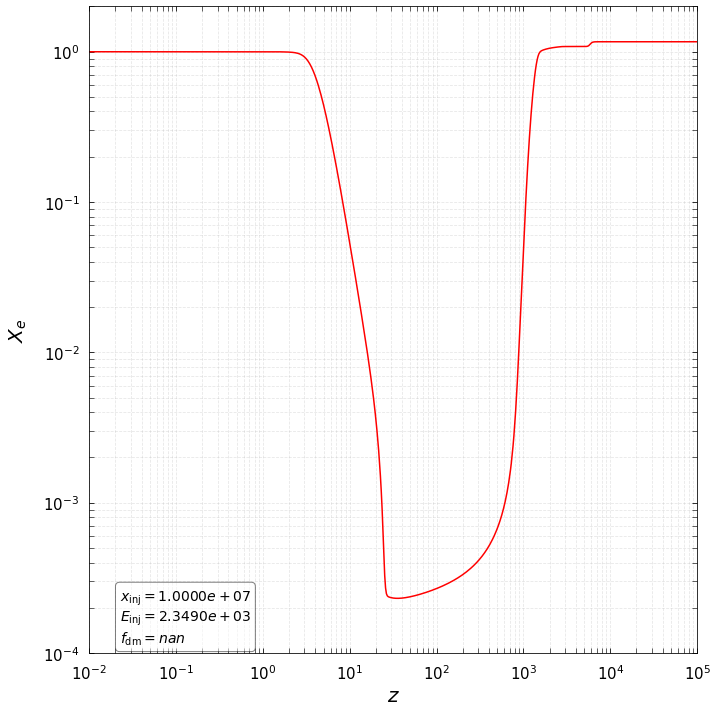

In [6]:

i = 0
#i = 46
for gamma_asked in sd_lib_extended_run.Gamma_values:
    nx = len(sd_lib_extended_run.x_inj_values)
    x = []
    y = []
    xinj = []
    fdm_values = []
    #z_asked = np.logspace(-2,5,1e3)
    for k in range(nx):
        xinj.append(sd_lib_extended_run.x_inj_values[k])
        #S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
        x.append(sd_lib_extended_run.DXe_Xe_redshifts_2d[i][k])
        y.append(sd_lib_extended_run.Xe_2d[i][k])
        fdm_values.append(sd_lib_extended_run.finj_2d[i][k][0]/1.3098e4*sd_lib_extended_run.x_inj_values[k])
    print(gamma_asked)

    z_no_inj = sd_lib_extended_run.DXe_Xe_redshifts_2d[0][0]
    Xe_no_inj = sd_lib_extended_run.Xe_no_inj_2d[0][0]
    
    #xinj = np.logspace(-8,7,nx)
    x_min = 1.e-2
    x_max = 1.e5
    #raise

    fig, ax1 = plt.subplots(1,1,figsize=(10,10))
    label_size = 15
    title_size = 20
    legend_size = 25
    handle_length = 1.5

    ymin = 1.e-4
    ymax = 2


    linesp = []
    patches = []


    i_ax = 0



    for ax in [ax1]:
        ax.set_xlim(x_min,x_max)
        ax.set_ylim(ymin,ymax)
        ax.set_xscale('log')
        ax.set_yscale('log')


        #ax.set_xlabel("scaled injection frequency, "+ r'$x_\mathrm{inj}=h\nu_\mathrm{inj}/k_{_\mathrm{B}}T_{\gamma}$',size=title_size)
        ax.set_xlabel(r'$z$',size=title_size)
        ax.set_ylabel(r'$X_e$',size=title_size)
        ax.yaxis.set_label_coords(-.1,0.5)

        # ticks_array = np.logspace(-6,6,13)
        # ax.set_xticks(ticks_array)

        # ticks_array = np.logspace(-8,2,11)
        # ax.set_yticks(ticks_array)


        ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
        ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

        plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
        plt.setp(ax.get_xticklabels(), fontsize=label_size)

        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.plot(z_no_inj,Xe_no_inj,c='r')



        plt.grid( b=True, which="both", alpha=0.3, linestyle='--')

        i_ax = i_ax + 1


    linesp1 = [ax1.plot([], [],c='k',ls='-')[0] for _ in range(1)]
    text_gamma =  [ax.text(0.05, 0.15, r'$x_\mathrm{inj}= %.4e$'%1, transform=ax.transAxes, fontsize=14, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))]
    patches1 = linesp1 + text_gamma 


    patches = patches1




    def init():

        for line in linesp1:
            line.set_data([], [])

        return patches

    def animate(i):
        for j,line in enumerate(linesp1):
            if j==0:
                line.set_data(x[i],y[i])
            text_gamma[j].remove()
            einj = xinj_to_Einj*xinj[i]
            text_gamma_str1 = r'$x_\mathrm{inj}= %.4e$'%xinj[i]
            text_gamma_str2 = r'$E_\mathrm{inj}= %.4e$'%einj
            text_gamma_str3 = r'$f_\mathrm{dm}= %.4e$'%fdm_values[i]
            text_gamma_str = '\n'.join((text_gamma_str1,text_gamma_str2,text_gamma_str3))
 
            text_gamma[j] = ax.text(0.05, 0.1, text_gamma_str , transform=ax.transAxes, fontsize=14, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        return patches


    fig.tight_layout()





    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(y), interval=800, blit=True)

    anim.save(path_to_figures + '/Xe_movie_Drho_rho_3e-5_zlate_1e3_G_'+'%.4e'%gamma_asked+'_with_coll.mp4', fps=3, extra_args=['-vcodec', 'libx264'],dpi=100)
    #plt.show()
    i+=1

In [14]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_without_collision_20x20_170820',sd_lib_extended_run)
pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_5e-6_no_collision_160820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [26]:
xinj_to_Einj*1.6e-4

3.7584e-08

In [9]:
p_array = [1e-8,1e-6,1e-4,1e-2,1e0,1e2,1e4,1e6,1e8]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'no'

ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0
ct.ct_Drho_rho_dec = 3e-5
ct.ct_include_pi = 1 
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_stim = 1
ct.ct_zlate = 1e3
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 0
ct.ct_include_collisions = 1
ct.ct_pi_energy_norm = 2
R_stim = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 1e-100
R_hubble_stim = ct.run_cosmotherm_parallel(**args)

problem


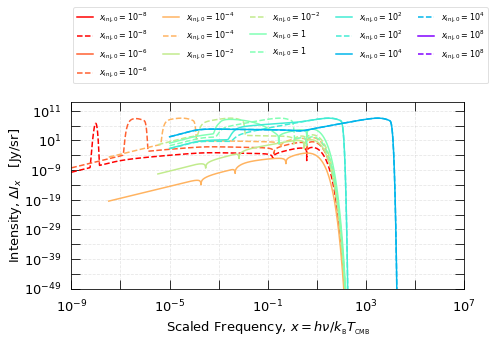

In [24]:


fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 0.8



ymin=1e-49
ymax = 1e14
x_min = 1e-9
x_max = 1e7
ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.rainbow(np.linspace(1,0,len(p_array))))
for x in p_array:
    col = next(color)
    try:
        ax.plot(R_stim[i]['x'],np.abs(R_stim[i]['DI']-R_hubble_stim[i]['DI'])/R_stim[i]['finj'],
                label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c=col,ls='-')
        ax.plot(R_no_stim[i]['x'],np.abs(R_no_stim[i]['DI']-R_hubble_no_stim[i]['DI'])/R_no_stim[i]['finj'],
            label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c=col,ls='--')
        #ax.plot(R_reio[i]['x'],np.abs(R_reio[i]['DI']-R_hubble_reio[i]['DI'])/R_reio[i]['finj'],
        #    c=col,ls='--',label='reio')
        #
        #ax.plot(R_lyc_reio[i]['x'],np.abs(R_lyc_reio[i]['DI']-R_hubble_lyc_reio[i]['DI'])/R_reio[i]['finj'],
        #    c=col,ls=':',label='lyc+reio')
    except:
        print('problem')
    i += 1



#ax.text(0.75, 0.1, r'$\Gamma_\mathrm{inj}=$'+scientific_notation(1e-20)+r'$\,\mathrm{s}^{-1}$', transform=ax.transAxes, 
#        fontsize=11, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))
#ax.text(0.02, 0.1, r'$f_\mathrm{inj}=1$', transform=ax.transAxes, fontsize=11, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))

# plt.ylim(-2.,5)
#plt.xlim(1e-3,13)

ax.legend(loc=(0.005,1.1),ncol=5,frameon=True,framealpha=0.6,fontsize = 8)

fig.tight_layout()

#plt.savefig(path_to_figures + '/figures_for_paper_long_lived_spectra.pdf')
plt.show()
plt.close(fig)

In [2]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_5e-6_no_collision_160820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [10]:
sd_lib = sd_lib_extended_run


Nx = 300
xi_array = np.logspace(-6,6,Nx)

Gamma_values = [1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17]
gamma_labels = [r'$10^{-8}$',r'$10^{-9}$',r'$10^{-10}$',r'$10^{-11}$',r'$10^{-12}$',r'$10^{-13}$',r'$10^{-14}$',r'$10^{-15}$',r'$10^{-16}$',r'$10^{-17}$']






firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'yes'

f_dm_fisher_lyc_reio_with_edges = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib,**a_dict)

a_dict['add_edges'] = 'no'

f_dm_fisher_lyc_reio_no_edges = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib,**a_dict)




In [10]:
f_dm_fisher_lyc_reio_no_edges['curves'][7]

{'x': array([1.00000000e-06, 1.09681601e-06, 1.20300535e-06, 1.31947552e-06,
        1.44722187e-06, 1.58733611e-06, 1.74101565e-06, 1.90957383e-06,
        2.09445114e-06, 2.29722754e-06, 2.51963593e-06, 2.76357701e-06,
        3.03113550e-06, 3.32459793e-06, 3.64647222e-06, 3.99950910e-06,
        4.38672559e-06, 4.81143084e-06, 5.27725435e-06, 5.78817704e-06,
        6.34856522e-06, 6.96320794e-06, 7.63735792e-06, 8.37677640e-06,
        9.18778243e-06, 1.00773068e-05, 1.10529514e-05, 1.21230540e-05,
        1.32967597e-05, 1.45840988e-05, 1.59960730e-05, 1.75447489e-05,
        1.92433614e-05, 2.11064268e-05, 2.31498667e-05, 2.53911443e-05,
        2.78494135e-05, 3.05456825e-05, 3.35029934e-05, 3.67466194e-05,
        4.03042803e-05, 4.42063797e-05, 4.84862648e-05, 5.31805113e-05,
        5.83292359e-05, 6.39764396e-05, 7.01703829e-05, 7.69639990e-05,
        8.44153460e-05, 9.25881025e-05, 1.01552113e-04, 1.11383983e-04,
        1.22167735e-04, 1.33995527e-04, 1.46968439e-04, 1.6

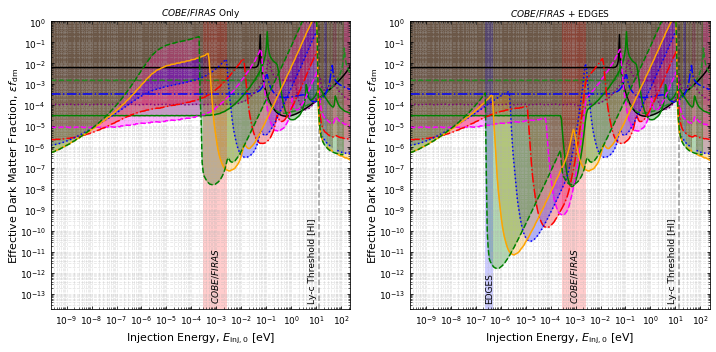

In [11]:
# photon_injection_case = 'bare'
# if photon_injection_case == 'bare':
#     f_dm_fisher = f_dm_fisher_bare
#     case = 'bare'
# if photon_injection_case == 'lyc':
#     f_dm_fisher = f_dm_fisher_lyc
#     case = 'lyc'
# if photon_injection_case == 'lyc_reio':
photon_injection_case = 'extended_run'
#     f_dm_fisher = f_dm_fisher_lyc_reio
#  
case = 'extended run'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['k','forestgreen','b','purple','green','magenta','r','b','orange','green','magenta'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    if ax == ax2:
        ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=1, facecolor='blue', alpha=0.2)
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    ax.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
i = 0
#color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
#for gamma in np.flip(Gamma_values):
for gamma in np.flip(Gamma_values):
    #if i<=2 or i%2==0:
    #    i += 1
    #    continue
    col = next(colors)
    mk = next(mklist)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    style = next(lstyles)
    f_dm_fisher = f_dm_fisher_lyc_reio_no_edges
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,
             label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)

    f_dm_fisher = f_dm_fisher_lyc_reio_with_edges
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

# ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax1.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.25, 0.02, r'EDGES' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax1.set_ylim(2.e-14,1e0)
ax1.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

ax2.set_ylim(2.e-14,1e0)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)
ax1.set_title(r'$COBE/FIRAS$ Only',fontsize=9)
ax2.set_title(r'$COBE/FIRAS$ + EDGES',fontsize=9)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
#ax1.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
#ax2.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_edges_'+photon_injection_case+'.pdf')
plt.show()
plt.close(fig)

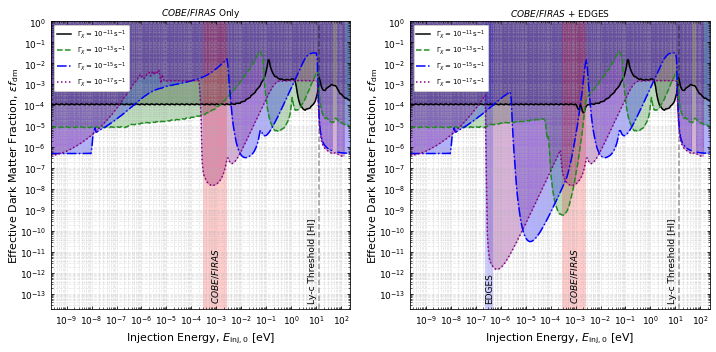

In [8]:
# photon_injection_case = 'bare'
# if photon_injection_case == 'bare':
#     f_dm_fisher = f_dm_fisher_bare
#     case = 'bare'
# if photon_injection_case == 'lyc':
#     f_dm_fisher = f_dm_fisher_lyc
#     case = 'lyc'
# if photon_injection_case == 'lyc_reio':
photon_injection_case = 'extended_run'
#     f_dm_fisher = f_dm_fisher_lyc_reio
#  
case = 'extended run'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['k','forestgreen','b','purple','green','magenta','r','b','orange','green','magenta'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    if ax == ax2:
        ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=1, facecolor='blue', alpha=0.2)
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    ax.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
i = 0
#color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
#for gamma in np.flip(Gamma_values):
for gamma in np.flip(Gamma_values):
    if i<=2 or i%2==0:
        i += 1
        continue
    col = next(colors)
    mk = next(mklist)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    style = next(lstyles)
    f_dm_fisher = f_dm_fisher_lyc_reio_no_edges
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,
             label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)

    f_dm_fisher = f_dm_fisher_lyc_reio_with_edges
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

# ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax1.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.25, 0.02, r'EDGES' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax1.set_ylim(2.e-14,1e0)
ax1.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

ax2.set_ylim(2.e-14,1e0)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)
ax1.set_title(r'$COBE/FIRAS$ Only',fontsize=9)
ax2.set_title(r'$COBE/FIRAS$ + EDGES',fontsize=9)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_edges_'+photon_injection_case+'.pdf')
plt.show()
plt.close(fig)

In [ ]:
sd

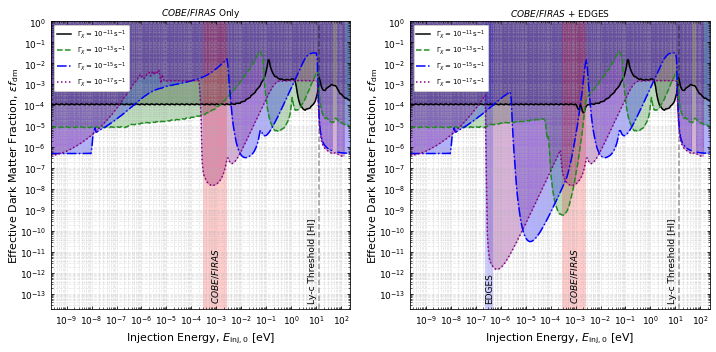

In [8]:
# photon_injection_case = 'bare'
# if photon_injection_case == 'bare':
#     f_dm_fisher = f_dm_fisher_bare
#     case = 'bare'
# if photon_injection_case == 'lyc':
#     f_dm_fisher = f_dm_fisher_lyc
#     case = 'lyc'
# if photon_injection_case == 'lyc_reio':
photon_injection_case = 'extended_run'
#     f_dm_fisher = f_dm_fisher_lyc_reio
#  
case = 'extended run'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['k','forestgreen','b','purple','green','magenta','r','b','orange','green','magenta'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    if ax == ax2:
        ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=1, facecolor='blue', alpha=0.2)
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    ax.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
i = 0
#color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
#for gamma in np.flip(Gamma_values):
for gamma in np.flip(Gamma_values):
    if i<=2 or i%2==0:
        i += 1
        continue
    col = next(colors)
    mk = next(mklist)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    style = next(lstyles)
    f_dm_fisher = f_dm_fisher_lyc_reio_no_edges
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,
             label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)

    f_dm_fisher = f_dm_fisher_lyc_reio_with_edges
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=style, marker='None')
    ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],c=col,ls=style, marker='None')
    ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

# ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
#           bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax1.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.25, 0.02, r'EDGES' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)

ax1.set_ylim(2.e-14,1e0)
ax1.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

ax2.set_ylim(2.e-14,1e0)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)
ax1.set_title(r'$COBE/FIRAS$ Only',fontsize=9)
ax2.set_title(r'$COBE/FIRAS$ + EDGES',fontsize=9)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=2,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_edges_'+photon_injection_case+'.pdf')
plt.show()
plt.close(fig)

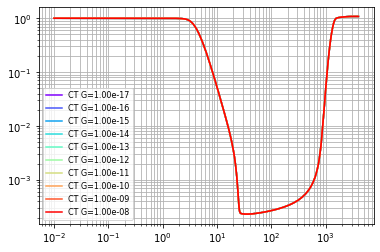

In [17]:
gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),10)
colors = iter(cm.rainbow(np.linspace(0, 1, len(gi_array))))
z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
xdec = 1.e3
rf = sd.recfast()
rf.rf_xinj0 = xdec

rf.rf_Reionization_model = 1
for i in range(len(gi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = gi_array[i]
    xinj = xdec
    S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    
    plt.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls='-',label='CT G=%.2e'%gamma)

    
plt.loglog()
plt.grid(which='both')
plt.legend(loc=3,fontsize=8)
#plt.savefig(path_to_figures + 'CT_recfast_comparison_no_inj.pdf')

Text(0.5, 1.0, '$\\Gamma_X=$$10^{-17}$$\\,\\mathrm{s^{-1}}$')

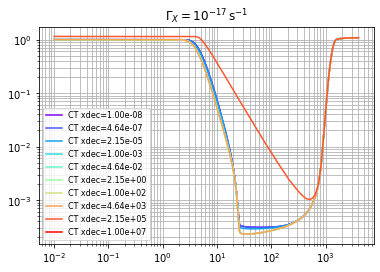

In [12]:
gi_array = 1e-17

z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
xdec = np.logspace(np.log10(1e-8),np.log10(1e7),10)
colors = iter(cm.rainbow(np.linspace(0, 1, len(xdec))))
rf = sd.recfast()
rf.rf_xinj0 = xdec

rf.rf_Reionization_model = 1
for i in range(len(xdec)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = gi_array
    xinj = xdec[i]
    S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    
    plt.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls='-',label='CT xdec=%.2e'%xinj)

    
plt.loglog()
plt.grid(which='both')
plt.legend(loc=3,fontsize=8)
plt.title(r'$\Gamma_X=$'+scientific_notation(gi_array)+r'$\,\mathrm{s^{-1}}$')
#plt.savefig(path_to_figures + 'CT_recfast_comparison_no_inj.pdf')

In [50]:
S_xe_history['Xe']


array([1.05880259, 1.05880263, 1.05880268, ..., 1.08189   , 1.08189   ,
       1.08189   ])

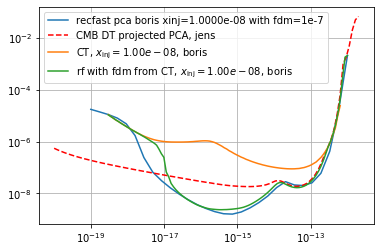

In [13]:

a_dict = {}
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 1e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 0

rf.rf_Reionization_model = 1

rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422
a_dict['recfast'] = rf


gi_array = np.logspace(np.log10(1e-19),np.log10(1e-12),30)
xdec = [1e-8]



rf_fdm_pca = pi_run_pca_constraints_with_recfast(xdec,gi_array,1e-7,**a_dict)

for i in range(len(rf_fdm_pca['curves'])):
    plt.plot(rf_fdm_pca['curves'][i]['Gamma_inj'],rf_fdm_pca['curves'][i]['fdm'],label='recfast pca boris xinj=%.4e with fdm=1e-7'%rf_fdm_pca['xinj'][i])



PCA = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/fdm_PCA_limits.dat')
plt.plot(PCA[:,0],PCA[:,1],c='r',ls='--',label='CMB DT projected PCA, jens')

gamma_inj = np.logspace(np.log10(3e-19),-12,100)
for xinj in [1e-8,1e-4,1e-2,1e2, 1e4, 1e6][0:1]:
    fdm_pca = []
    fdm_pca_recfast = []
    #xinj = 1e-8
    z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
    for gamma_asked in gamma_inj:
        #S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_xe_history)
        S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
        fdm_pca.append(S_xe_history['fdm_pca_lim'])
        xdec = [xinj]
        gi_array = [gamma_asked]
        fdm_pca_recfast_p = pi_run_pca_constraints_with_recfast(xdec,gi_array,S_xe_history['fdm'],**a_dict)
        fdm_pca_recfast.append(fdm_pca_recfast_p['curves'][0]['fdm'][0])
    fdm_pca = np.asarray(fdm_pca)
    fdm_pca_recfast = np.asarray(fdm_pca_recfast)
    plt.plot(gamma_inj,fdm_pca,label=r'CT, $x_\mathrm{inj}=%.2e$, boris'%xinj)
    plt.plot(gamma_inj,fdm_pca_recfast,label=r'rf with fdm from CT, $x_\mathrm{inj}=%.2e$, boris'%xinj)



plt.loglog()
plt.grid(which='both')
plt.legend()
#plt.savefig(path_to_figures + 'pca-comparison_fdm_1e-5_w_reio.pdf')

In [54]:
firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'yes'
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 1e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 0
rf.rf_Reionization_model = 1
rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422

a_dict['recfast'] = rf
a_dict['sd_lib'] = sd_lib
fdm_fisher = []
fdm_pca_rf = []
fdm_pca_ct = []

Nx = 50
xi_array = np.logspace(-8,6,Nx)

for gamma in [1e-15]:
    print(gamma)
    for xinj in xi_array:
        #print(xinj)
    #    f_dm_fisher = sd.pi_run_fisher_constraints([gamma],[xinj],**a_dict)
    #    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #    print(fdm_value)
    #    f_dm_pca = pi_run_pca_constraints_with_recfast([xinj],[gamma],fdm_value,**a_dict)
    #    fdm_pca_value = f_dm_pca['curves'][0]['fdm'][0]
    #    print(fdm_pca_value)
    
        fdm_results = get_fdm_constraints_at_Gamma_and_xinj(gamma,xinj,**a_dict)
        fdm_fisher.append(fdm_results['fdm_fisher'])
        fdm_pca_rf.append(fdm_results['fdm_Xe_pca_rf'])
        fdm_pca_ct.append(fdm_results['fdm_Xe_pca_ct'])
fdm_fisher = np.asarray(fdm_fisher)
fdm_pca_rf = np.asarray(fdm_pca_rf)
fdm_pca_ct = np.asarray(fdm_pca_ct)



1e-15


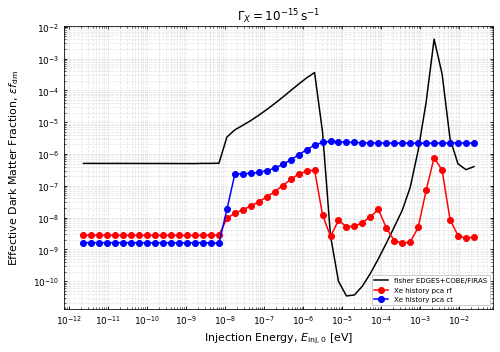

In [55]:
photon_injection_case = 'lyc_reio'

fig, (ax1) = plt.subplots(1,1,figsize=(7,5))
ax = ax1
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_fdm,size=title_size)
ax.set_xlabel(label_injection_energy,size=title_size)
ax.yaxis.set_label_coords(-.10,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.plot(xinj_to_Einj*xi_array,fdm_fisher,c='k',label='fisher EDGES+COBE/FIRAS',ls='-', marker='None')
ax.plot(xinj_to_Einj*xi_array,fdm_pca_rf,c='r',label='Xe history pca rf',ls='-', marker='o')
ax.plot(xinj_to_Einj*xi_array,fdm_pca_ct,c='b',label='Xe history pca ct',ls='-', marker='o')

plt.title(r'$\Gamma_X=$'+scientific_notation(gamma)+r'$\,\mathrm{s^{-1}}$')

ax.legend(loc=4,ncol=1,frameon=True,framealpha=1.,fontsize = 7)


# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
#plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_edges_'+photon_injection_case+'_pca_vs_fisher.pdf')
plt.show()
plt.close(fig)

In [ ]:
sd_lib_extended_run.

In [ ]:
GetSpectra(Gamma_inj_asked,x_inj_asked,x_asked,specdist_ct_spectra_lib)

In [3]:
#i = 46
i=0
gamma_asked = sd_lib_extended_run.Gamma_values[i]
nx = len(sd_lib_extended_run.x_inj_values)
x = []
y = []
xinj = []
fdm_values = []
#z_asked = np.logspace(-2,5,1e3)
for k in range(nx):
    xinj.append(sd_lib_extended_run.x_inj_values[k])
    #S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
    x.append(sd_lib_extended_run.X_2d[i][k])
    y.append(sd_lib_extended_run.DI_2d[i][k])
    fdm_values.append(sd_lib_extended_run.finj_2d[i][k][0]/1.3098e4*sd_lib_extended_run.x_inj_values[k])
print(gamma_asked)

1e-08


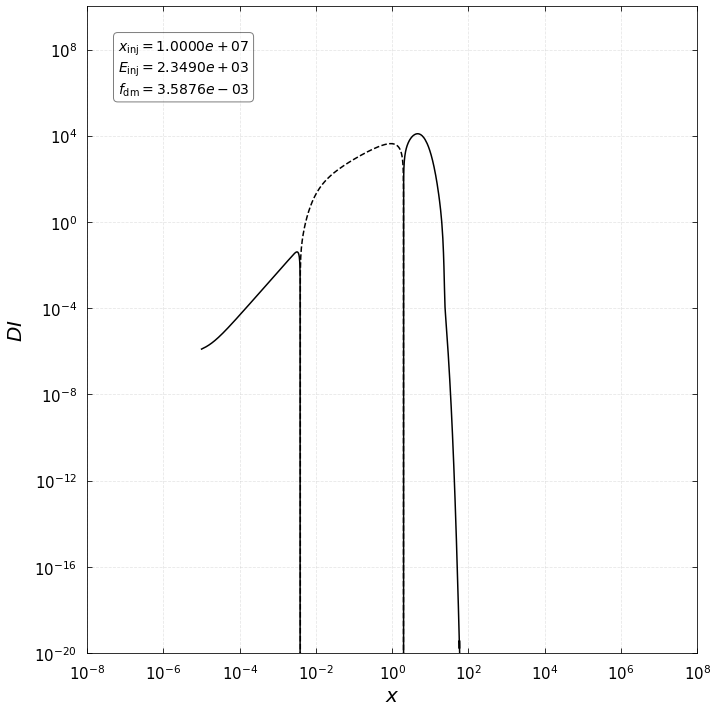

In [5]:
import matplotlib.animation as animation
#xinj = np.logspace(-8,7,nx)
x_min = 1.e-8
x_max = 1.e8
#raise

fig, ax1 = plt.subplots(1,1,figsize=(10,10))
label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5

ymin = 1.e-20
ymax = 1e10


linesp = []
patches = []


i_ax = 0



for ax in [ax1]:
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    #ax.set_xlabel("scaled injection frequency, "+ r'$x_\mathrm{inj}=h\nu_\mathrm{inj}/k_{_\mathrm{B}}T_{\gamma}$',size=title_size)
    ax.set_xlabel(r'$x$',size=title_size)
    ax.set_ylabel(r'$DI$',size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)

    # ticks_array = np.logspace(-6,6,13)
    # ax.set_xticks(ticks_array)

    # ticks_array = np.logspace(-8,2,11)
    # ax.set_yticks(ticks_array)


    ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

    plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
    plt.setp(ax.get_xticklabels(), fontsize=label_size)

    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')



    plt.grid( b=True, which="both", alpha=0.3, linestyle='--')

    i_ax = i_ax + 1


linesp1 = [ax1.plot([], [],c='k',ls='-')[0] for _ in range(1)]
linesm1 = [ax1.plot([], [],c='k',ls='--')[0] for _ in range(1)]
text_gamma =  [ax.text(0.05, 0.15, r'$x_\mathrm{inj}= %.4e$'%1, transform=ax.transAxes, fontsize=14, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))]
patches1 = linesp1 + linesm1 + text_gamma 


patches = patches1




def init():

    for line in linesp1:
        line.set_data([], [])
    for line in linesm1:
        line.set_data([], [])

    return patches

def animate(i):
    for j,line in enumerate(linesm1):
        if j==0:
            line.set_data(x[i],-y[i])
    for j,line in enumerate(linesp1):
        if j==0:
            line.set_data(x[i],y[i])
        text_gamma[j].remove()
        einj = xinj_to_Einj*xinj[i]
        text_gamma_str1 = r'$x_\mathrm{inj}= %.4e$'%xinj[i]
        text_gamma_str2 = r'$E_\mathrm{inj}= %.4e$'%einj
        text_gamma_str3 = r'$f_\mathrm{dm}= %.4e$'%fdm_values[i]
        text_gamma_str = '\n'.join((text_gamma_str1,text_gamma_str2,text_gamma_str3))
        text_gamma[j] = ax.text(0.05, 0.95, text_gamma_str , transform=ax.transAxes, fontsize=14, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    return patches


fig.tight_layout()





anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(y), interval=800, blit=True)

anim.save(path_to_figures + '/DI_movie_Drho_rho_3e-5_G_'+'%.4e'%gamma_asked+'_no_coll.mp4', fps=3, extra_args=['-vcodec', 'libx264'],dpi=100)
#plt.show()

In [31]:
gamma_asked = 1e-16
nx = 200
x = []
y = []
fdm_values = []
z_asked = np.logspace(-2,5,1e3)
for k in range(nx):
    xinj = np.logspace(-8,7,nx)[k]
    S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
    x.append(S_xe_history['z'])
    y.append(S_xe_history['Xe'])
    fdm_values.append(S_xe_history['fdm'])
    
    

In [ ]:
sd_lib_extended_run.

In [6]:

i = 0
#i = 46
gamma_asked = sd_lib_extended_run.Gamma_values[i]
nx = len(sd_lib_extended_run.x_inj_values)
x = []
y = []
xinj = []
fdm_values = []
#z_asked = np.logspace(-2,5,1e3)
for k in range(nx):
    xinj.append(sd_lib_extended_run.x_inj_values[k])
    #S_xe_history = pi.GetXeHistory(gamma_asked,xinj,z_asked,sd_lib_extended_run)
    x.append(sd_lib_extended_run.DXe_Xe_redshifts_2d[i][k])
    y.append(sd_lib_extended_run.Xe_2d[i][k])
    fdm_values.append(sd_lib_extended_run.finj_2d[i][k][0]/1.3098e4*sd_lib_extended_run.x_inj_values[k])
print(gamma_asked)

z_no_inj = sd_lib_extended_run.DXe_Xe_redshifts_2d[0][0]
Xe_no_inj = sd_lib_extended_run.Xe_no_inj_2d[0][0]

1e-14


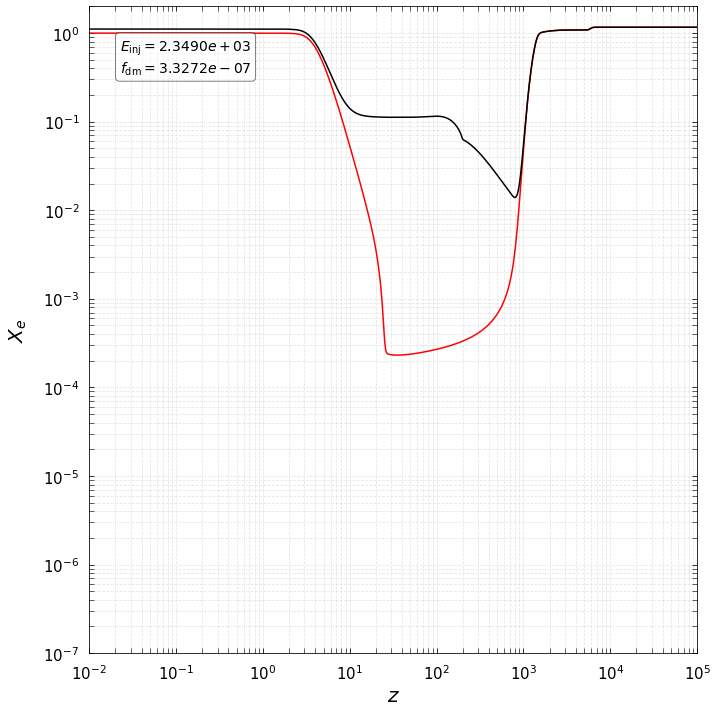

In [7]:
#xinj = np.logspace(-8,7,nx)
x_min = 1.e-2
x_max = 1.e5
#raise

fig, ax1 = plt.subplots(1,1,figsize=(10,10))
label_size = 15
title_size = 20
legend_size = 25
handle_length = 1.5

ymin = 1.e-7
ymax = 2


linesp = []
patches = []


i_ax = 0



for ax in [ax1]:
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    #ax.set_xlabel("scaled injection frequency, "+ r'$x_\mathrm{inj}=h\nu_\mathrm{inj}/k_{_\mathrm{B}}T_{\gamma}$',size=title_size)
    ax.set_xlabel(r'$z$',size=title_size)
    ax.set_ylabel(r'$X_e$',size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)

    # ticks_array = np.logspace(-6,6,13)
    # ax.set_xticks(ticks_array)

    # ticks_array = np.logspace(-8,2,11)
    # ax.set_yticks(ticks_array)


    ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

    plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
    plt.setp(ax.get_xticklabels(), fontsize=label_size)

    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.plot(z_no_inj,Xe_no_inj,c='r')



    plt.grid( b=True, which="both", alpha=0.3, linestyle='--')

    i_ax = i_ax + 1


linesp1 = [ax1.plot([], [],c='k',ls='-')[0] for _ in range(1)]
text_gamma =  [ax.text(0.05, 0.15, r'$x_\mathrm{inj}= %.4e$'%1, transform=ax.transAxes, fontsize=14, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))]
patches1 = linesp1 + text_gamma 


patches = patches1




def init():

    for line in linesp1:
        line.set_data([], [])

    return patches

def animate(i):
    for j,line in enumerate(linesp1):
        if j==0:
            line.set_data(x[i],y[i])
        text_gamma[j].remove()
        einj = xinj_to_Einj*xinj[i]
        text_gamma_str1 = r'$E_\mathrm{inj}= %.4e$'%einj
        text_gamma_str2 = r'$f_\mathrm{dm}= %.4e$'%fdm_values[i]
        text_gamma_str = '\n'.join((text_gamma_str1,text_gamma_str2))
        text_gamma[j] = ax.text(0.05, 0.95, text_gamma_str , transform=ax.transAxes, fontsize=14, verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    return patches


fig.tight_layout()





anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(y), interval=800, blit=True)

anim.save(path_to_figures + '/Xe_movie_Drho_rho_5e-6_G_1e-14_no_coll.mp4', fps=3, extra_args=['-vcodec', 'libx264'],dpi=100)
#plt.show()

In [8]:
xinj_to_Einj

0.0002349

In [12]:
path_to_ct_spectra_results=sd.path_to_ct_spectra_results

In [17]:
xmin = 1e-9
xmax = 1e7
Gamma_min = 1e-8


p_array = [xmin]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'yes'


ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0

ct.ct_include_pi = 1 
ct.ct_Gamma_dec = Gamma_min
ct.ct_pi_stim = 0
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 1
ct.ct_pi_energy_norm = 2

ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1


results = compute_no_injection_spectrum_and_Xe_history(ct,**args)

In [30]:
np.logspace(-8,-20,80)[75]

4.051304969235378e-20

(1e-10, 10000.0)

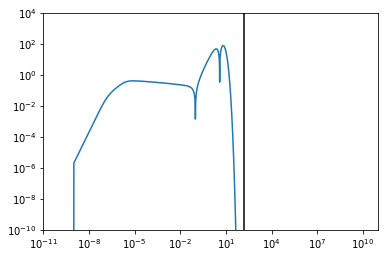

In [19]:
plt.plot(results['x'],np.abs(results['DI']))
#plt.plot(R_no_inj_low_x_reio[0]['x'],np.abs(R_no_inj_low_x_reio[0]['DI']))
#plt.plot(R_no_inj_low_x_reio_2[0]['x'],np.abs(R_no_inj_low_x_reio_2[0]['DI']),ls='--')
plt.loglog()
plt.axvline(1.5e2,c='k')
plt.ylim(1.e-10,1e4)

(1e-10, 10000.0)

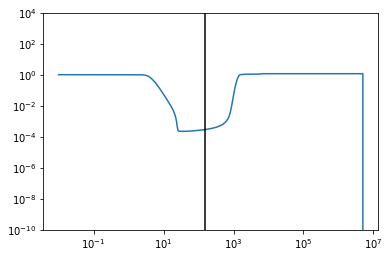

In [21]:
plt.plot(results['Xe_redshifts'],np.abs(results['Xe_values']))
#plt.plot(R_no_inj_low_x_reio[0]['x'],np.abs(R_no_inj_low_x_reio[0]['DI']))
#plt.plot(R_no_inj_low_x_reio_2[0]['x'],np.abs(R_no_inj_low_x_reio_2[0]['DI']),ls='--')
plt.loglog()
plt.axvline(1.5e2,c='k')
plt.ylim(1.e-10,1e4)

In [16]:
def compute_no_injection_spectrum_and_Xe_history(self,**kwargs):
    r_dict = {}
    self.ct_Drho_rho_dec = 1e-300
    
    Nx_no_inj = kwargs.get('Nx_no_inj', 5e3)
    Nz_no_inj = kwargs.get('Nz_no_inj', 5e3)
    xmin = kwargs.get('xmin_no_inj', 1e-10)
    xmax = kwargs.get('xmax_no_inj', 1e10)
    
    R = self.run_cosmotherm_parallel(**kwargs)
    
    f_DI_no_inj = interp1d(R[0]['x'],R[0]['DI'],bounds_error=False,fill_value=1e-300)
    
    new_x = np.logspace(np.log10(xmin),np.log10(xmax),Nx_no_inj)
    new_DI_no_inj = f_DI_no_inj(new_x)
    
    r_dict['x'] = new_x
    r_dict['DI'] = new_DI_no_inj
    
    if self.save_Xe == 'yes' and self.ct_evolve_Xe != 0 :
        f_Xe_no_inj = interp1d(R[0]['Xe_redshifts'],R[0]['Xe_values'],bounds_error=False,fill_value=1e-300)
        new_Xe_redshifts_ct = np.logspace(np.log10(self.ct_zend),np.log10(self.ct_zstart),Nz_no_inj)
        new_Xe_values_ct = f_Xe_no_inj(new_Xe_redshifts_ct)
        r_dict['Xe_redshifts'] = new_Xe_redshifts_ct
        r_dict['Xe_values'] = new_Xe_values_ct
        
    if kwargs['save_spectra']=='yes':
        with open(path_to_ct_spectra_results+'/'+self.save_dir_name + '/spectra_' + self.save_dir_name  + '_no_injection_DI_ct.txt', 'w') as f:
            f.write("# arrays of DI values for CT spectra\n")
            for row in [new_DI_no_inj]:
                np.savetxt(f,[row],fmt="%.8e",delimiter='\t')
        f.close()
        with open(path_to_ct_spectra_results+'/'+self.save_dir_name + '/spectra_' + self.save_dir_name  + '_no_injection_x_ct.txt', 'w') as f:
            f.write("# arrays of x values for CT spectra\n")
            for row in [new_x]:
                np.savetxt(f,[row],fmt="%.8e",delimiter='\t')
        f.close()
        if self.save_Xe == 'yes' and self.ct_evolve_Xe != 0 :
            with open(path_to_ct_spectra_results+'/'+self.save_dir_name + '/spectra_' + self.save_dir_name  + '_no_injection_Xe_redshifts_ct.txt', 'w') as f:
                f.write("# arrays of redshift values for free electron fraction Xe\n")
                for row in [new_Xe_redshifts_ct]:
                    np.savetxt(f,[row],fmt="%.3e",delimiter='\t')
            f.close()
            with open(path_to_ct_spectra_results+'/'+self.save_dir_name + '/spectra_' + self.save_dir_name  + '_no_injection_Xe_values_ct.txt', 'w') as f:
                f.write("# arrays of Xe values for free electron fraction Xe\n")
                for row in [new_Xe_values_ct]:
                    np.savetxt(f,[row],fmt="%.8e",delimiter='\t')
            f.close()
    return r_dict

In [56]:
case = 'extended_run_xe_history_120820'
case_id = "case_" + case
id_Gamma = 50
path_to_ct_database = sd.path_to_ct_database
Gi = 1e-8
str_gamma = str("%.3e"%Gi)
print('G=%s'%str_gamma)

path_to_spectra  = path_to_ct_database + case_id + '/' + case


x_ct = []
x_ct_no_injection = []
filename = path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma + '_x_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_ct.append(x_ct_p)
filename = path_to_spectra + '_no_injection' + '/spectra_' + case + '_no_injection_fine_grid' + '_x_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_ct_no_injection.append(x_ct_p)




DI_ct = []
DI_ct_bare = []
DI_ct_no_injection = []
filename = path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma  + '_DI_ct.txt'
filename_no_injection = path_to_spectra + '_no_injection' +  '/spectra_'  + case + '_no_injection_fine_grid' +  '_DI_ct.txt'





with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_bare.append(DI_ct_p)

with open(filename_no_injection) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_no_injection.append(DI_ct_p)

            
f_DI_no_injection = interp1d(x_ct_no_injection[0],DI_ct_no_injection[0])

        
for (p_bare,x_array) in zip(DI_ct_bare,x_ct):
    p_no_injection = f_DI_no_injection(x_array)
    DI_ct.append(p_bare-p_no_injection)


G=1.000e-08


In [77]:
Xe_values_ct = []
Xe_values_no_inj_ct = []
Xe_redshifts_ct = []
Xe_redshifts_no_inj_ct = []
Xe_redshifts_no_inj_fine_grid_ct = []
Xe_values_no_inj_fine_grid_ct = []
filename = path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma  + '_Xe_values_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            Xe_values_ct.append(DI_ct_p)

filename_no_injection = path_to_spectra + '_no_injection' +  '/spectra_'  + case + '_no_injection_fine_grid' +  '_Xe_values_ct.txt'

with open(filename_no_injection) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            Xe_values_no_inj_fine_grid_ct.append(DI_ct_p)

            
filename = path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma  + '_Xe_redshifts_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            Xe_redshifts_ct.append(DI_ct_p)

filename_no_injection = path_to_spectra + '_no_injection' +  '/spectra_'  + case + '_no_injection_fine_grid' +  '_Xe_redshifts_ct.txt'
with open(filename_no_injection) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            Xe_redshifts_no_inj_fine_grid_ct.append(DI_ct_p)
f_Xe = interp1d(Xe_redshifts_no_inj_fine_grid_ct[0],Xe_values_no_inj_fine_grid_ct[0])
for (p_Xe, p_z) in zip(Xe_values_ct,Xe_redshifts_ct):
    Xe_redshifts_no_inj_ct.append(p_z)
    Xe_values_no_inj_ct.append(f_Xe(p_z))
    
    


(1e-10, 1000.0)

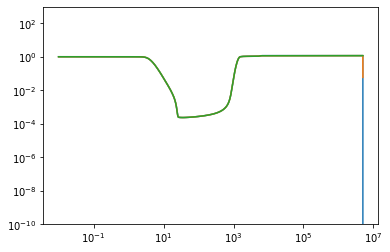

In [79]:

plt.plot(Xe_redshifts_no_inj_fine_grid_ct[0],np.abs(Xe_values_no_inj_fine_grid_ct[0]))

plt.plot(Xe_redshifts_no_inj_ct[0],np.abs(Xe_values_no_inj_ct[0]))
plt.plot(Xe_redshifts_ct[0],np.abs(Xe_values_ct[0]))

plt.loglog()
plt.ylim(1e-10,1e3)

(1e-10, 1000.0)

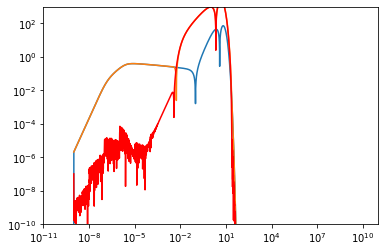

In [59]:

plt.plot(x_ct_no_injection[0],np.abs(DI_ct_no_injection[0]))
plt.plot(x_ct[0],np.abs(DI_ct_bare[0]))
plt.plot(x_ct[0],np.abs(DI_ct[0]),c='r')
plt.loglog()
plt.ylim(1e-10,1e3)

In [ ]:
p_array = [1e1]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'no'


ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0
ct.ct_Drho_rho_dec = 3e-6
ct.ct_include_pi = 1 
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_stim = 1
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 0
ct.ct_pi_energy_norm = 2
R = ct.run_cosmotherm_parallel(**args)

In [90]:
#ct.ct_Drho_rho_dec = 1e-100
#ct.ct_zend = 1e6

xmin = 1e-9
xmax = 1e7
Gamma_min = 1e-8


ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0

ct.ct_include_pi = 1 
ct.ct_Gamma_dec = Gamma_min
ct.ct_pi_stim = 0
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 1
ct.ct_pi_energy_norm = 2

#set injection amplitude to ~0
ct.ct_Drho_rho_dec = 1e-300

ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1


p_array = [xmin]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'no'

In [91]:
R = ct.run_cosmotherm_parallel(**args)

In [ ]:
xmin = 1e-9
xmax = 1e8
Nx_no_inj = 5e3 
f_DI_no_inj = interp1d(R[0]['x'],R[0]['DI'],bounds_error=False,fill_value=1e-300)
new_x = np.logspace(np.log10(xmin),np.log10(xmax),Nx_no_inj)
f_DI_no_inj(new_x)

self = ct

(1e-10, 10000.0)

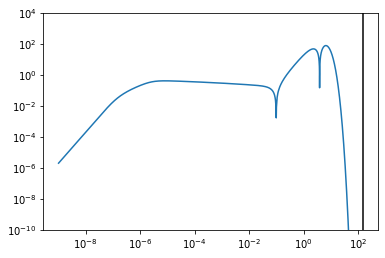

In [88]:
plt.plot(R[0]['x'],np.abs(R[0]['DI']))
#plt.plot(R_no_inj_low_x_reio[0]['x'],np.abs(R_no_inj_low_x_reio[0]['DI']))
#plt.plot(R_no_inj_low_x_reio_2[0]['x'],np.abs(R_no_inj_low_x_reio_2[0]['DI']),ls='--')
plt.loglog()
plt.axvline(1.5e2,c='k')
plt.ylim(1.e-10,1e4)

In [67]:
p_array = [xmax]
args['param_values_array'] = p_array




R_no_inj_high_x = ct.run_cosmotherm_parallel(**args)

In [61]:
R_no_inj_high_x[0]['x']

array([1.00000000e-05, 1.01237277e-05, 1.02489862e-05, ...,
       2.14745002e+05, 2.15462333e+05, 2.16182060e+05])

(1e-10, 10000.0)

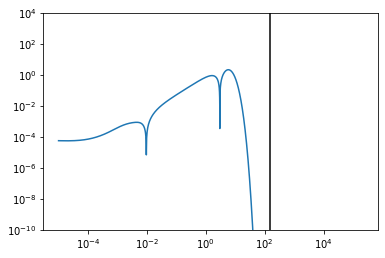

In [68]:
plt.plot(R_no_inj_high_x[0]['x'],np.abs(R_no_inj_high_x[0]['DI']))
plt.loglog()
plt.axvline(1.5e2,c='k')
plt.ylim(1.e-10,1e4)

In [ ]:
specdist_ct_spectra_lib.path_to_spectra

In [ ]:
np.loadtxt('/Use')

In [16]:
p_array = [1e1]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'no'
args['dict_for_fisher'] = {}
args['sd_lib_for_fisher'] = None

ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0
ct.ct_Drho_rho_dec = 3e-6
ct.ct_include_pi = 1 
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_stim = 0
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 0
ct.ct_pi_energy_norm = 2
R_no_stim = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 1e-100
R_hubble_no_stim = ct.run_cosmotherm_parallel(**args)

In [ ]:
p_array = [1e1]
p_name = 'photon injection x_dec'

args = {}
args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_spectra'] = 'no'
args['dict_for_fisher'] = {}
args['sd_lib_for_fisher'] = None

ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=0
ct.ct_Drho_rho_dec = 3e-6
ct.ct_include_pi = 1 
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_stim = 0
ct.save_dir_name = 'test' 
ct.ct_reionisation_model = 0
ct.ct_pi_energy_norm = 2



In [20]:
R_no_stim[0]['finj']

2.89727e-06

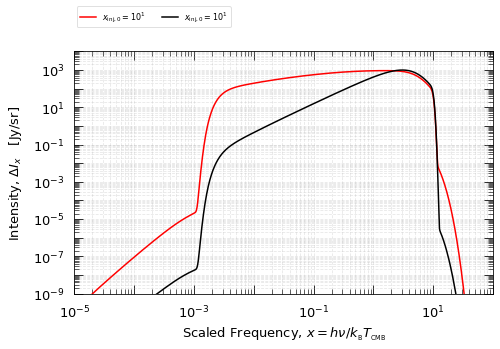

In [21]:


fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 0.8



ymin=1e-9
ymax = 1e4
x_min = 1e-5
x_max = 1e2
ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.rainbow(np.linspace(1,0,len(p_array))))
for x in p_array:
    col = next(color)
    
    ax.plot(R[i]['x'],np.abs(R[i]['DI']-R_hubble[i]['DI']),#/R[i]['finj'],
            label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c=col,ls='-')
    ax.plot(R_no_stim[i]['x'],np.abs(R_no_stim[i]['DI']-R_hubble_no_stim[i]['DI']),#/R[i]['finj'],
        label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c='k',ls='-')
    #ax.plot(R_reio[i]['x'],np.abs(R_reio[i]['DI']-R_hubble_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls='--',label='reio')
    #
    #ax.plot(R_lyc_reio[i]['x'],np.abs(R_lyc_reio[i]['DI']-R_hubble_lyc_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls=':',label='lyc+reio')
    i += 1



#ax.text(0.75, 0.1, r'$\Gamma_\mathrm{inj}=$'+scientific_notation(1e-20)+r'$\,\mathrm{s}^{-1}$', transform=ax.transAxes, 
#        fontsize=11, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))
#ax.text(0.02, 0.1, r'$f_\mathrm{inj}=1$', transform=ax.transAxes, fontsize=11, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))

# plt.ylim(-2.,5)
#plt.xlim(1e-3,13)

ax.legend(loc=(0.005,1.1),ncol=5,frameon=True,framealpha=0.6,fontsize = 8)

fig.tight_layout()

#plt.savefig(path_to_figures + '/figures_for_paper_long_lived_spectra.pdf')
plt.show()
plt.close(fig)

In [39]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('extended_run_xe_history_010820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [73]:
id_Gamma = 50
specdist_ct_spectra_lib = sd_lib_extended_run
Gi = specdist_ct_spectra_lib.Gamma_values[id_Gamma]
str_gamma = str("%.3e"%Gi)
print('G=%s'%str_gamma)

case = 'extended_run_xe_history_010820'

#read x array
x_ct = []
if case == 'mu_fit':
    filename = specdist_ct_spectra_lib.path_to_spectra + '/spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma +'/spectra_spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma  + '_x_ct.txt'
elif 'xe_history' in case or 'quasistable_particle' in case:
    filename = specdist_ct_spectra_lib.path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma + '_x_ct.txt'
else:
    filename = specdist_ct_spectra_lib.path_to_spectra + '/spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma + '_x_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_ct.append(x_ct_p)


#read DI array
DI_ct = []
if case == 'mu_fit':
    DI_ct_bare = []
    DI_ct_hubble = []
    filename = specdist_ct_spectra_lib.path_to_spectra + '/spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma +'/spectra_spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma  + '_DI_ct.txt'
    filename_hubble = specdist_ct_spectra_lib.path_to_spectra + '/spectra_' + specdist_ct_spectra_lib.case_id + '_hubble_G_' + str_gamma +'/spectra_spectra_' + specdist_ct_spectra_lib.case_id + '_hubble_G_' + str_gamma  + '_DI_ct.txt'
    with open(filename) as f:
        for line in f:
            ls = line.strip()
            if ls:
                if "#" in ls:
                    continue
                else:
                    DI_ct_p = []
                    l = re.split('\t',ls)
                    l = [e for e in l if e]
                    #print(l)
                    for s in l:
                        DI_cti = float(s)
                        DI_ct_p.append(DI_cti)
                    DI_ct_p = np.asarray(DI_ct_p)
                DI_ct_bare.append(DI_ct_p)
    with open(filename_hubble) as f:
        for line in f:
            ls = line.strip()
            if ls:
                if "#" in ls:
                    continue
                else:
                    DI_ct_p = []
                    l = re.split('\t',ls)
                    l = [e for e in l if e]
                    #print(l)
                    for s in l:
                        DI_cti = float(s)
                        DI_ct_p.append(DI_cti)
                    DI_ct_p = np.asarray(DI_ct_p)
                DI_ct_hubble.append(DI_ct_p)
    for (p_bare,p_hubble) in zip(DI_ct_bare,DI_ct_hubble):
        DI_ct.append(p_bare-p_hubble)
elif 'xe_history' in case or 'quasistable_particle' in case:
    DI_ct_bare = []
    DI_ct_hubble = []
    filename = specdist_ct_spectra_lib.path_to_spectra + '_G_' + str_gamma + '/spectra_' + case + '_G_' + str_gamma  + '_DI_ct.txt'
    filename_hubble = specdist_ct_spectra_lib.path_to_spectra + '_hubble_G_' + str_gamma + '/spectra_'  + case + '_hubble_G_' + str_gamma  + '_DI_ct.txt'
    with open(filename) as f:
        for line in f:
            ls = line.strip()
            if ls:
                if "#" in ls:
                    continue
                else:
                    DI_ct_p = []
                    l = re.split('\t',ls)
                    l = [e for e in l if e]
                    #print(l)
                    for s in l:
                        DI_cti = float(s)
                        DI_ct_p.append(DI_cti)
                    DI_ct_p = np.asarray(DI_ct_p)
                DI_ct_bare.append(DI_ct_p)
    with open(filename_hubble) as f:
        for line in f:
            ls = line.strip()
            if ls:
                if "#" in ls:
                    continue
                else:
                    DI_ct_p = []
                    l = re.split('\t',ls)
                    l = [e for e in l if e]
                    #print(l)
                    for s in l:
                        DI_cti = float(s)
                        DI_ct_p.append(DI_cti)
                    DI_ct_p = np.asarray(DI_ct_p)
                DI_ct_hubble.append(DI_ct_p)
    for (p_bare,p_hubble) in zip(DI_ct_bare,DI_ct_hubble):
        DI_ct.append(p_bare-p_hubble)
else:
    filename = specdist_ct_spectra_lib.path_to_spectra + '/spectra_' + specdist_ct_spectra_lib.case_id + '_G_' + str_gamma + '_DI_ct.txt'
    with open(filename) as f:
        for line in f:
            ls = line.strip()
            if ls:
                if "#" in ls:
                    continue
                else:
                    DI_ct_p = []
                    l = re.split('\t',ls)
                    l = [e for e in l if e]
                    #print(l)
                    for s in l:
                        DI_cti = float(s)
                        DI_ct_p.append(DI_cti)
                    DI_ct_p = np.asarray(DI_ct_p)
                DI_ct.append(DI_ct_p)



G=1.283e-12


In [74]:
DI_ct_hubble[0]

array([1.69070181e-06, 1.74535362e-06, 1.80133009e-06, ...,
       1.82143536e-54, 1.12653541e-54, 4.17488650e-55])

In [50]:
DI_ct_hubble[0]

array([1.69070181e-06, 1.74535362e-06, 1.80133009e-06, ...,
       1.82143536e-54, 1.12653541e-54, 4.17488650e-55])

(1e-09, 10000.0)

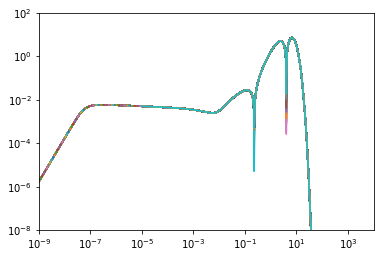

In [75]:
for i in range(np.shape(DI_ct_hubble)[0]):
    try:
        plt.plot(x_ct[i],np.abs(DI_ct_hubble[i]))
    except ValueError:
        pass
plt.loglog()
plt.ylim(1e-8,1e2)
plt.xlim(1e-9,1e4)

(0.0001, 100.0)

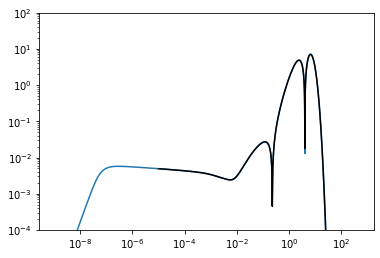

In [76]:
i = 0
plt.plot(x_ct[i],np.abs(DI_ct_hubble[i]))
i = 219
plt.plot(x_ct[i],np.abs(DI_ct_hubble[i]),c='k')
plt.loglog()
plt.ylim(1e-4,1e2)
#plt.xlim(1e-6,1e-4)

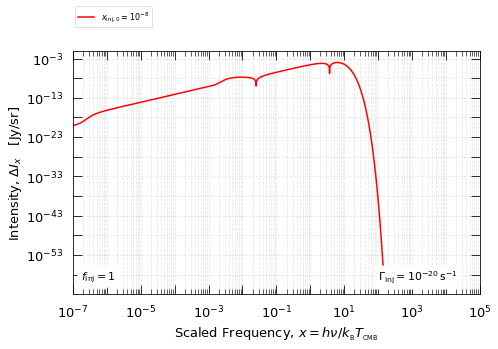

In [6]:


fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 0.8



ymin=1e-12
ymax = 1e-2
x_min = 1e-7
x_max = 1e5
ax.set_xlim(x_min,x_max)
#ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.rainbow(np.linspace(1,0,len(p_array))))
for x in p_array:
    col = next(color)
    
    ax.plot(R[i]['x'],np.abs(R[i]['DI']-R_hubble[i]['DI'])/R[i]['finj'],
            label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c=col,ls='-')
    #ax.plot(R_reio[i]['x'],np.abs(R_reio[i]['DI']-R_hubble_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls='--',label='reio')
    #
    #ax.plot(R_lyc_reio[i]['x'],np.abs(R_lyc_reio[i]['DI']-R_hubble_lyc_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls=':',label='lyc+reio')
    i += 1



ax.text(0.75, 0.1, r'$\Gamma_\mathrm{inj}=$'+scientific_notation(1e-20)+r'$\,\mathrm{s}^{-1}$', transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))
ax.text(0.02, 0.1, r'$f_\mathrm{inj}=1$', transform=ax.transAxes, fontsize=11, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))

# plt.ylim(-2.,5)
#plt.xlim(1e-3,13)

ax.legend(loc=(0.005,1.1),ncol=5,frameon=True,framealpha=0.6,fontsize = 8)

fig.tight_layout()

#plt.savefig(path_to_figures + '/figures_for_paper_long_lived_spectra.pdf')
plt.show()
plt.close(fig)

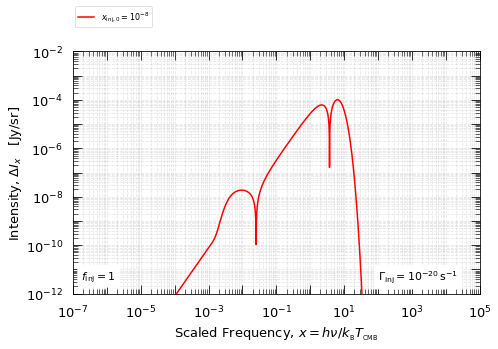

In [7]:


fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 0.8



ymin=1e-12
ymax = 1e-2
x_min = 1e-7
x_max = 1e5
ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)


ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
i = 0
color=iter(cm.rainbow(np.linspace(1,0,len(p_array))))
for x in p_array:
    col = next(color)
    
    ax.plot(R[i]['x'],np.abs(R[i]['DI']-R_hubble[i]['DI'])/R[i]['finj'],
            label=r'$x_\mathrm{inj,0}=$'+scientific_notation(x),c=col,ls='-')
    #ax.plot(R_reio[i]['x'],np.abs(R_reio[i]['DI']-R_hubble_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls='--',label='reio')
    #
    #ax.plot(R_lyc_reio[i]['x'],np.abs(R_lyc_reio[i]['DI']-R_hubble_lyc_reio[i]['DI'])/R_reio[i]['finj'],
    #    c=col,ls=':',label='lyc+reio')
    i += 1



ax.text(0.75, 0.1, r'$\Gamma_\mathrm{inj}=$'+scientific_notation(1e-20)+r'$\,\mathrm{s}^{-1}$', transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))
ax.text(0.02, 0.1, r'$f_\mathrm{inj}=1$', transform=ax.transAxes, fontsize=11, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white'))

# plt.ylim(-2.,5)
#plt.xlim(1e-3,13)

ax.legend(loc=(0.005,1.1),ncol=5,frameon=True,framealpha=0.6,fontsize = 8)

fig.tight_layout()

#plt.savefig(path_to_figures + '/figures_for_paper_long_lived_spectra.pdf')
plt.show()
plt.close(fig)